In [13]:
#https://rdrr.io/github/mnsentinellakes/mnsentinellakes/

import pandas as pd
from pandasql import sqldf
qr = lambda q: sqldf(q, globals())
from duckdb import query as qr

### BRING IN AND FORMAT ALL LAKES
lakes_stg = pd.read_csv ('all_lakes.csv', converters={'ID': lambda x: str(x)})


lk2 = """SELECT DISTINCT
            *
            ,case when instr("Nearest Town",'(') = 0 then "Nearest Town"
                else rtrim(substr("Nearest Town",0,instr("Nearest Town",'('))) end as nearest_town
        FROM lakes_stg
    ;"""
lakes = qr(lk2).to_df()

lakes['ID']  = lakes['ID'].apply(lambda x: "0" + x if int(x) <= 9017800 else x )

lake_water_details = pd.read_csv ('lake_water_details_all.csv', converters={'lake_id': lambda x: str(x)})
lake_water_details['area'] = lake_water_details['area'].astype(str).str.replace(',', '').astype(float)
lake_water_details['littoral_area'] = lake_water_details['littoral_area'].astype(str).str.replace(',', '').astype(float)

#for column area, remove comma and then convert to float
# lake_master_latest['area'] = lake_master_latest['area'].str.replace(',', '').astype(float)
# lake_master_latest['littoral_area'] = lake_master_latest['littoral_area'].str.replace(',', '').astype(float)

ramps = pd.read_csv ('ramps_all.csv', converters={'lake_id': lambda x: str(x)})

lat_long = pd.read_csv ('lat_long_all.csv', converters={'lake_id': lambda x: str(x)})

uscities_lat_long = pd.read_csv ('uscities.csv', converters={'lake_id': lambda x: str(x)})
uscities_lat_long = uscities_lat_long[uscities_lat_long.state_id == 'MN']
uscities_lat_long = uscities_lat_long[['city','county_name','lat','lng','density']]

basin_coordinates = pd.read_csv ('basin_coordinates.csv', converters={'lake_id': lambda x: str(x)})


##shoreline class
shoreline_class = pd.read_csv ('DNR_Shoreline_Classifications.csv', converters={'dowlknum': lambda x: str(x)})
shoreline_class.loc[shoreline_class.dowlknum <= '9017800', "dowlknum"] = "0"+shoreline_class.dowlknum
shoreline_class.rename(columns = {'dowlknum':'lake_id'}, inplace = True)

#Get lake classes.  These are the schupp lake classes
lake_classes = pd.read_csv ('lake_classes.csv', converters={'dowlknum': lambda x: str(x)})
lake_classes.rename(columns={'dowlknum':'lake_id'}, inplace=True)

# Read in new JSON sourced data and format as needed
survey_details = pd.read_csv ('survey_details.csv', converters={'lake_id': lambda x: str(x)})
survey_details['surveyDate'] = pd.to_datetime(survey_details['surveyDate'])

catch_summaries = pd.read_csv ('catch_summaries.csv', converters={'lake_id': lambda x: str(x)})
catch_lengths = pd.read_csv ('catch_lengths.csv', converters={'lake_id': lambda x: str(x)})
fishabbreviations = pd.read_csv ('fishabbreviations.csv')

catch_summaries.rename(columns={'species':'species_id'}, inplace=True)
catch_lengths.rename(columns={'species':'species_id'}, inplace=True)

catch_summaries = qr("SELECT a.*,b.Name as species FROM catch_summaries as a LEFT JOIN fishabbreviations as b ON a.species_id = b.Code").to_df()
catch_lengths = qr("SELECT a.*,b.Name as species FROM catch_lengths as a LEFT JOIN fishabbreviations as b ON a.species_id = b.Code").to_df()

cols = catch_summaries.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
catch_summaries = catch_summaries[cols]

cols = catch_lengths.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
catch_lengths = catch_lengths[cols]


catch_lengths = qr("""SELECT *
                               ,cast((length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14+length_15+length_16+length_17+length_18+length_19
                                    +length_20+length_21+length_22+length_23+length_24+length_25+length_26+length_27+length_28+length_29+length_30+length_31+length_32+length_33+length_34+length_35+length_36+length_37+length_38
                                    +length_39+length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47+length_48+length_49+length_50) as float) as total_length_n
                                from catch_lengths""").to_df()

catch_lengths = qr("""SELECT *,
                        cast((length_1*1 + length_2*2 + length_3*3 + length_4*4 + length_5*5 + length_6*6 + length_7*7 + length_8*8 + length_9*9 + length_10*10 + length_11*11 + length_12*12 + length_13*13 + length_14*14 + length_15*15 + length_16*16 + length_17*17 + length_18*18 + length_19*19
                        + length_20*20 + length_21*21 + length_22*22 + length_23*23 + length_24*24 + length_25*25 + length_26*26 + length_27*27 + length_28*28 + length_29*29 + length_30*30 + length_31*31 + length_32*32 + length_33*33 + length_34*34 + length_35*35 + length_36*36 + length_37*37 + length_38*38
                        + length_39*39 + length_40*40 + length_41*41 + length_42*42 + length_43*43 + length_44*44 + length_45*45 + length_46*46 + length_47*47 + length_48*48 + length_49*49 + length_50*50) as float)/total_length_n as avg_length
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6)) as float) as num_gte_6
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6)) as float)/total_length_n as prcnt_gte_6
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6)) as float) as num_gte_7
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6)) as float)/total_length_n as prcnt_gte_7
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7)) as float) as num_gte_8
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7)) as float)/total_length_n as prcnt_gte_8
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8)) as float)/total_length_n as prcnt_gte_9
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8)) as float) as num_gte_9
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9)) as float) as num_gte_10
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9)) as float)/total_length_n as prcnt_gte_10
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10)) as float) as num_gte_11
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10)) as float)/total_length_n as prcnt_gte_11
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11)) as float) as num_gte_12
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11)) as float)/total_length_n as prcnt_gte_12
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14)) as float) as num_gte_15
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14)) as float)
                                /total_length_n as prcnt_gte_15
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14
                            +length_16+length_15+length_17)) as float) as num_gte_18
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14
                            +length_16+length_15+length_17)) as float) /total_length_n as prcnt_gte_18
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14
                                +length_16+length_15+length_17+length_18+length_19)) as float) as num_gte_20
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14
                                +length_16+length_15+length_17+length_18+length_19)) as float) /total_length_n as prcnt_gte_20
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14+length_16+length_15+length_17
                                +length_18+length_19+length_21+length_20+length_22+length_23+length_24)) as float) as num_gte_25
                        ,cast((total_length_n-(length_1+length_2+length_3+length_4+length_5+length_6+length_7+length_8+length_9+length_10+length_11+length_12+length_13+length_14+length_16+length_15+length_17
                                +length_18+length_19+length_21+length_20+length_22+length_23+length_24)) as float) /total_length_n as prcnt_gte_25
                        ,cast((length_30+length_31+length_32+length_33+length_34+length_35+length_36+length_37+length_38+length_39+length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47
                            +length_48+length_49+length_50) as float) as num_gte_30
                        ,cast((length_30+length_31+length_32+length_33+length_34+length_35+length_36+length_37+length_38+length_39+length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47
                            +length_48+length_49+length_50) as float)/total_length_n as prcnt_gte_30
                        ,cast((length_35+length_36+length_37+length_38+length_39+length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47+length_48+length_49+length_50) as float) as num_gte_35
                        ,cast((length_35+length_36+length_37+length_38+length_39+length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47+length_48+length_49+length_50) as float)
                            /total_length_n as prcnt_gte_35
                        ,cast((length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47+length_48+length_49+length_50) as float) as num_gte_40
                        ,cast((length_40+length_41+length_42+length_43+length_44+length_45+length_46+length_47+length_48+length_49+length_50) as float)/total_length_n as prcnt_gte_40
                                FROM catch_lengths """).to_df()



latest_standard_survey = qr("""
                            select *
                            from survey_details as a
                            inner join (select lake_id, max(surveyID) as surveyID from survey_details
                                        where surveyType = 'Standard Survey'
                                        group by lake_id) as b
                            on a.lake_id = b.lake_id and a.surveyID = b.surveyID
                            """).to_df()

# Get the latest STANDARD survey data.  Only include catches using standard equipment 'Standard gill nets','Standard trap nets'; 
catch_summaries_standard = qr("SELECT * FROM catch_summaries WHERE surveyID IN (SELECT surveyID FROM survey_details WHERE surveyType = 'Standard Survey') and gear IN ('Standard gill nets','Standard trap nets')").to_df()

# merge in surveyDate from survey_details to catch_summaries_standard; only 1960 and later
catch_summaries_standard = qr("""SELECT a.*, 
           b.surveyDate, 
           strftime('%Y', CAST(b.surveyDate AS DATE)) AS survey_year
    FROM catch_summaries_standard AS a
    LEFT JOIN survey_details AS b
    ON CAST(a.surveyID AS VARCHAR) = CAST(b.surveyID AS VARCHAR)
    WHERE survey_year >= '1970'""").to_df()

catch_summaries_latest = qr("SELECT a.* FROM catch_summaries as a INNER JOIN latest_standard_survey as b ON a.lake_id = b.lake_id WHERE a.surveyID = b.surveyID").to_df()

catch_lengths_standard= qr("SELECT * FROM catch_lengths WHERE surveyID IN (SELECT surveyID FROM survey_details WHERE surveyType = 'Standard Survey')").to_df()

catch_lengths_latest = qr("SELECT a.* FROM catch_lengths as a INNER JOIN latest_standard_survey as b ON a.lake_id = b.lake_id WHERE a.surveyID = b.surveyID").to_df()

#build a subset of species and gear for historical analysis
# catch_summaries_historical = qr("""SELECT *,strftime('%Y', surveyDate) AS survey_year
#                                      FROM catch_summaries_standard
#                                      WHERE species_id||gear IN ('BLCStandard trap nets','BLGStandard trap nets','NOPStandard gill nets','WAEStandard gill nets')
#                                         and surveyDate >= '1970-01-01'""")


In [2]:
#Survey Weight

float_cols=['CPUE','averageWeight']
catch_summaries_standard = (catch_summaries_standard.drop(float_cols, axis=1)
         .join(catch_summaries_standard[float_cols].apply(pd.to_numeric, errors='coerce')))

catch_summaries_standard.loc[catch_summaries_standard.gear.isin(['Standard gill nets','Standard trap nets']), "standard_gear"] = 1
catch_summaries_standard.loc[catch_summaries_standard.standard_gear != 1, "standard_gear"] = 0

catch_summaries_standard[['CPUE_low','CPUE_high']] = catch_summaries_standard['quartileCount'].str.split('-',expand=True)
catch_summaries_standard[['Weight_low','Weight_high']] = catch_summaries_standard['quartileWeight'].str.split('-',expand=True)

catch_summaries_sgn = catch_summaries_standard[catch_summaries_standard.gear == 'Standard gill nets'].groupby(['species']).agg(
    cpue_sgn_max = pd.NamedAgg(column='CPUE', aggfunc='max')
    ,cpue_sgn_mean = pd.NamedAgg(column='CPUE', aggfunc='mean')
    ,cpue_sgn_med = pd.NamedAgg(column='CPUE', aggfunc='median')
    ,cpue_sgn_std = pd.NamedAgg(column='CPUE', aggfunc='std')
    ,weight_sgn_max = pd.NamedAgg(column='averageWeight', aggfunc='max')
    ,weight_sgn_mean = pd.NamedAgg(column='averageWeight', aggfunc='mean')
    ,weight_sgn_med = pd.NamedAgg(column='averageWeight', aggfunc='median')
    ,weight_sgn_std = pd.NamedAgg(column='averageWeight', aggfunc='std')
).reset_index()

catch_summaries_stn = catch_summaries_standard[catch_summaries_standard.gear == 'Standard trap nets'].groupby(['species']).agg(
    cpue_stn_max = pd.NamedAgg(column='CPUE', aggfunc='max')
    ,cpue_stn_mean = pd.NamedAgg(column='CPUE', aggfunc='mean')
    ,cpue_stn_med = pd.NamedAgg(column='CPUE', aggfunc='median')
    ,cpue_stn_std = pd.NamedAgg(column='CPUE', aggfunc='std')
    ,weight_stn_max = pd.NamedAgg(column='averageWeight', aggfunc='max')
    ,weight_stn_mean = pd.NamedAgg(column='averageWeight', aggfunc='mean')
    ,weight_stn_med = pd.NamedAgg(column='averageWeight', aggfunc='median')
    ,weight_stn_std = pd.NamedAgg(column='averageWeight', aggfunc='std')
).reset_index()


q = """SELECT DISTINCT
        a.*
        ,case when gear <> 'Standard trap nets' then null
            else (CPUE-stn.cpue_stn_mean)/stn.cpue_stn_med end as cpue_stn_devs
        ,case when gear <> 'Standard gill nets' then null
            else (CPUE-sgn.cpue_sgn_mean)/sgn.cpue_sgn_med end as cpue_sgn_devs
        ,case when gear <> 'Standard trap nets' then null
            else ("averageWeight"-stn.weight_stn_mean)/stn.weight_stn_med end as weight_stn_devs
        ,case when gear <> 'Standard gill nets' then null
            else ("averageWeight"-sgn.weight_sgn_mean)/sgn.weight_sgn_med end as weight_sgn_devs
        FROM
            catch_summaries_standard as a
            left join catch_summaries_sgn as sgn on a.species = sgn.species
            left join catch_summaries_stn as stn on a.species = stn.species
    ;"""

catch_summaries_mast_1 = qr(q).to_df()

catch_summaries_mast_1['cpue_stn_prcntl_year'] = catch_summaries_mast_1.groupby(['species', 'survey_year'])['cpue_stn_devs']\
                        .rank(pct=True)
catch_summaries_mast_1['cpue_sgn_prcntl_year'] = catch_summaries_mast_1.groupby(['species', 'survey_year'])['cpue_sgn_devs']\
                        .rank(pct=True)
catch_summaries_mast_1['weight_stn_prcntl_year'] = catch_summaries_mast_1.groupby(['species', 'survey_year'])['weight_stn_devs']\
                        .rank(pct=True)
catch_summaries_mast_1['weight_sgn_prcntl_year'] = catch_summaries_mast_1.groupby(['species', 'survey_year'])['weight_sgn_devs']\
                        .rank(pct=True)

q2 = """SELECT DISTINCT
            lake_id
            ,surveyID
            ,survey_year
            ,surveyDate
            ,species_ID
            ,species
            ,max(case when gear = 'Standard trap nets' then totalCatch else 0 end) as stn_n
            ,max(case when gear = 'Standard gill nets' then totalCatch else 0 end) as sgn_n
            ,sum(totalCatch) as total_n
            ,max(case when gear = 'Standard trap nets' then "averageWeight" else 0 end) as stn_weight
            ,max(case when gear = 'Standard gill nets' then "averageWeight" else 0 end) as sgn_weight
            ,max(case when gear = 'Standard trap nets' then CPUE else 0 end) as stn_cpue
            ,max(case when gear = 'Standard gill nets' then CPUE else 0 end) as sgn_cpue
            ,max(cpue_stn_prcntl_year) as cpue_stn_prcntl_year
            ,max(cpue_sgn_prcntl_year) as cpue_sgn_prcntl_year
            ,max(weight_stn_prcntl_year) as weight_stn_prcntl_year
            ,max(weight_sgn_prcntl_year) as weight_sgn_prcntl_year
            --,case when max(cpue_stn_prcntl_year) is null or max(cpue_sgn_prcntl_year) is null then coalesce(cpue_stn_prcntl_year,cpue_sgn_prcntl_year)
             --   else (max(cpue_stn_prcntl_year)+max(cpue_sgn_prcntl_year)) / 2 end as cpue_avg_prcntl_year
            --,case when max(weight_stn_prcntl_year) is null or max(weight_sgn_prcntl_year) is null then coalesce(weight_stn_prcntl_year,weight_sgn_prcntl_year)
             --   else (max(weight_stn_prcntl_year)+max(weight_sgn_prcntl_year)) / 2 end as weight_avg_prcntl_year
        FROM catch_summaries_mast_1
        where standard_gear = 1
        group by 1,2,3,4,5,6
    ;"""

catch_summaries_mast_2 = qr(q2).to_df()

q3 = """SELECT DISTINCT
           lake_id
           ,SurveyID
           ,species
           ,case when stn_n*1 > sgn_n*1 then 'stn' else 'sgn' end as net_type
        FROM catch_summaries_mast_2
        
    ;"""

net_type = qr(q3).to_df()

q4 = """SELECT DISTINCT
           a.*
           ,b.net_type
           ,case when b.net_type = 'stn' then cpue_stn_prcntl_year else cpue_sgn_prcntl_year end as cpue_prcntl_year
           ,case when b.net_type = 'stn' then weight_stn_prcntl_year else weight_sgn_prcntl_year end as weigth_prcntl_year
        FROM catch_summaries_mast_2 as a
            left join net_type as b on a.species = b.species and a.lake_id = b.lake_id and a.SurveyID = b.SurveyID
    ;"""
 
catch_summaries_mast_4 = qr(q4).to_df()

# catch_summaries_mast_4.to_csv(r'catch_summaries_mast_4.csv', index = False)
# catch_summaries_mast_4


In [3]:
## survey length/Weight Combined

LW1 = """SELECT DISTINCT
            a.lake_id
            ,a.surveyID
            ,1 as has_weight_survey_ind
            ,case when b.lake_id is not null then 1 else 0 end has_length_survey_ind
            ,a.species
            ,a.total_n
            ,stn_n
            ,sgn_n
            ,stn_weight
            ,sgn_weight
            ,stn_cpue
            ,sgn_cpue
            ,cpue_stn_prcntl_year
            ,cpue_sgn_prcntl_year
            ,weight_stn_prcntl_year
            ,weight_sgn_prcntl_year
            ,a.net_type
            ,a.cpue_prcntl_year
            ,a.weigth_prcntl_year
            ,case when a.species = 'Northern Pike' then cpue_prcntl_year else null end as NP_cpue_prcntl_year
            ,case when a.species = 'Northern Pike' then weigth_prcntl_year else null end as NP_weigth_prcntl_year
            ,case when a.species = 'Northern Pike' then cpue_prcntl_year*weigth_prcntl_year else null end as NP_combined
            ,case when a.species = 'Bluegill' then cpue_prcntl_year else null end as BG_cpue_prcntl_year
            ,case when a.species = 'Bluegill' then weigth_prcntl_year else null end as BG_weigth_prcntl_year
            ,case when a.species = 'Bluegill' then cpue_prcntl_year*weigth_prcntl_year else null end as BG_combined
            ,case when a.species = 'Black Crappie' then cpue_prcntl_year else null end as CPB_cpue_prcntl_year
            ,case when a.species = 'Black Crappie' then weigth_prcntl_year else null end as CPB_weigth_prcntl_year
            ,case when a.species = 'Black Crappie' then cpue_prcntl_year*weigth_prcntl_year else null end as CPB_combined
            ,case when a.species = 'White Crappie' then cpue_prcntl_year else null end as CPW_cpue_prcntl_year
            ,case when a.species = 'White Crappie' then weigth_prcntl_year else null end as CPW_weigth_prcntl_year
            ,case when a.species = 'White Crappie' then cpue_prcntl_year*weigth_prcntl_year else null end as CPW_combined
            ,case when a.species = 'Pumpkinseed' then cpue_prcntl_year else null end as PNK_cpue_prcntl_year
            ,case when a.species = 'Pumpkinseed' then weigth_prcntl_year else null end as PNK_weigth_prcntl_year
            ,case when a.species = 'Pumpkinseed' then cpue_prcntl_year*weigth_prcntl_year else null end as PNK_combined
            ,case when a.species = 'Hybrid Sunfish' then cpue_prcntl_year else null end as SNH_cpue_prcntl_year
            ,case when a.species = 'Hybrid Sunfish' then weigth_prcntl_year else null end as SNH_weigth_prcntl_year
            ,case when a.species = 'Hybrid Sunfish' then cpue_prcntl_year*weigth_prcntl_year else null end as SNH_combined
            ,case when a.species = 'Green Sunfish' then cpue_prcntl_year else null end as SNG_cpue_prcntl_year
            ,case when a.species = 'Green Sunfish' then weigth_prcntl_year else null end as SNG_weigth_prcntl_year
            ,case when a.species = 'Green Sunfish' then cpue_prcntl_year*weigth_prcntl_year else null end as SNG_combined
            ,case when a.species = 'Yellow Perch' then cpue_prcntl_year else null end as YP_cpue_prcntl_year
            ,case when a.species = 'Yellow Perch' then weigth_prcntl_year else null end as YP_weigth_prcntl_year
            ,case when a.species = 'Yellow Perch' then cpue_prcntl_year*weigth_prcntl_year else null end as YP_combined
            ,case when a.species = 'Walleye' then cpue_prcntl_year else null end as WLY_cpue_prcntl_year
            ,case when a.species = 'Walleye' then weigth_prcntl_year else null end as WLY_weigth_prcntl_year
            ,case when a.species = 'Walleye' then cpue_prcntl_year*weigth_prcntl_year else null end as WLY_combined
            --length details
            ,length_1,length_2,length_3,length_4,length_5,length_6,length_7,length_8,length_9,length_10,length_11,length_12,length_13,length_14,length_15,length_16,length_17,length_18,length_19
            ,length_20,length_21,length_22,length_23,length_24,length_25,length_26,length_27,length_28,length_29,length_30,length_31,length_32,length_33,length_34,length_35,length_36,length_37,length_38
            ,length_39,length_40,length_41,length_42,length_43,length_44,length_45,length_46,length_47,length_48,length_49,length_50
            ,avg_length
            
            ,case when a.species = 'Northern Pike' then maximum_length end as NP_max_length
            ,case when a.species = 'Northern Pike' then avg_length end as NP_avg_length
            ,case when a.species = 'Northern Pike' then prcnt_gte_30 end as NP_30_plus_prcnt
            ,case when a.species = 'Northern Pike' then num_gte_30 end as NP_30_plus_num
            ,case when a.species = 'Northern Pike' then prcnt_gte_35 end as NP_35_plus_prcnt
            ,case when a.species = 'Northern Pike' then num_gte_35 end as NP_35_plus_num
            ,case when a.species = 'Northern Pike' then prcnt_gte_40 end as NP_40_plus_prcnt
            ,case when a.species = 'Northern Pike' then num_gte_40 end as NP_40_plus_num

            ,case when a.species = 'Bluegill' then maximum_length end as BG_max_length
            ,case when a.species = 'Bluegill' then avg_length end as BG_avg_length
            ,case when a.species = 'Bluegill' then num_gte_6 end as BG_6_plus_num
            ,case when a.species = 'Bluegill' then prcnt_gte_6 end as BG_6_plus_prcnt
            ,case when a.species = 'Bluegill' then num_gte_7 end as BG_7_plus_num
            ,case when a.species = 'Bluegill' then prcnt_gte_7 end as BG_7_plus_prcnt
            ,case when a.species = 'Bluegill' then num_gte_8 end as BG_8_plus_num
            ,case when a.species = 'Bluegill' then prcnt_gte_8 end as BG_8_plus_prcnt
            ,case when a.species = 'Bluegill' then num_gte_9 end as BG_9_plus_num
            ,case when a.species = 'Bluegill' then prcnt_gte_9 end as BG_9_plus_prcnt
            ,case when a.species = 'Bluegill' then num_gte_10 end as BG_10_plus_num
            ,case when a.species = 'Bluegill' then prcnt_gte_10 end as BG_10_plus_prcnt

            ,case when a.species = 'Black Crappie' then maximum_length end as CPB_max_length
            ,case when a.species = 'Black Crappie' then avg_length end as CPB_avg_length
            ,case when a.species = 'Black Crappie' then num_gte_8 end as CPB_8_plus_num
            ,case when a.species = 'Black Crappie' then prcnt_gte_8 end as CPB_8_plus_prcnt
            ,case when a.species = 'Black Crappie' then num_gte_10 end as CPB_10_plus_num
            ,case when a.species = 'Black Crappie' then prcnt_gte_10 end as CPB_10_plus_prcnt
            ,case when a.species = 'Black Crappie' then prcnt_gte_11 end as CPB_11_plus_prcnt
            ,case when a.species = 'Black Crappie' then num_gte_12 end as CPB_12_plus_num
            ,case when a.species = 'Black Crappie' then prcnt_gte_12 end as CPB_12_plus_prcnt
            
            ,case when a.species = 'Yellow Perch' then maximum_length end as YP_max_length
            ,case when a.species = 'Yellow Perch' then avg_length end as YP_avg_length
            ,case when a.species = 'Yellow Perch' then prcnt_gte_8 end as YP_8_plus_prcnt
            ,case when a.species = 'Yellow Perch' then prcnt_gte_9 end as YP_9_plus_prcnt
            ,case when a.species = 'Yellow Perch' then prcnt_gte_10 end as YP_10_plus_prcnt

            ,case when a.species = 'Walleye' then maximum_length end as WLY_max_length
            ,case when a.species = 'Walleye' then avg_length end as WLY_avg_length
            ,case when a.species = 'Walleye' then prcnt_gte_15 end as WLY_15_plus_prcnt
            ,case when a.species = 'Walleye' then prcnt_gte_20 end as WLY_20_plus_prcnt
            ,case when a.species = 'Walleye' then num_gte_25 end as WLY_25_plus_num
            ,case when a.species = 'Walleye' then prcnt_gte_25 end as WLY_25_plus_prcnt
            ,case when a.species = 'Walleye' then num_gte_30 end as WLY_30_plus_num
            ,case when a.species = 'Walleye' then prcnt_gte_30 end as WLY_30_plus_prcnt
        FROM catch_summaries_mast_4 as a
            left join catch_lengths_standard as b on a.lake_id = b.lake_id and a.species = b.species and a.surveyID = b.surveyID
    ;"""

survey_lngth_wght_mast_1 = qr(LW1).to_df()
survey_lngth_wght_mast_1

LW2 = """SELECT DISTINCT
            lake_id
            ,surveyID
            ,max(has_weight_survey_ind) as has_weight_survey_ind
            ,max(has_length_survey_ind) as has_length_survey_ind
            ,max(NP_avg_length) as NP_avg_length
            ,max(NP_max_length) as NP_max_length
            ,max(NP_cpue_prcntl_year) as NP_cpue_prcntl_year
            ,max(NP_weigth_prcntl_year) as NP_weigth_prcntl_year
            ,max(NP_combined) as NP_combined
            ,max(NP_30_plus_prcnt) as NP_30_plus_prcnt
            ,max(NP_35_plus_num) as NP_35_plus_num
            ,max(NP_35_plus_prcnt) as NP_35_plus_prcnt
            ,max(NP_40_plus_num) as NP_40_plus_num
            ,max(NP_40_plus_prcnt) as NP_40_plus_prcnt
            ,max(BG_avg_length) as BG_avg_length
            ,max(BG_max_length) as BG_max_length
            ,max(BG_cpue_prcntl_year) as BG_cpue_prcntl_year
            ,max(BG_weigth_prcntl_year) as BG_weigth_prcntl_year
            ,max(BG_combined) as BG_combined
            ,max(BG_6_plus_prcnt) as BG_6_plus_prcnt
            ,max(BG_7_plus_prcnt) as BG_7_plus_prcnt
            ,max(BG_8_plus_prcnt) as BG_8_plus_prcnt
            ,max(BG_9_plus_num) as BG_9_plus_num
            ,max(BG_9_plus_prcnt) as BG_9_plus_prcnt
            ,max(BG_10_plus_num) as BG_10_plus_num
            ,max(BG_10_plus_prcnt) as BG_10_plus_prcnt
            ,max(PNK_cpue_prcntl_year) as PNK_cpue_prcntl_year
            ,max(PNK_weigth_prcntl_year) as PNK_weigth_prcntl_year
            ,max(PNK_combined) as PNK_combined
            ,max(SNH_cpue_prcntl_year) as SNH_cpue_prcntl_year
            ,max(SNH_weigth_prcntl_year) as SNH_weigth_prcntl_year
            ,max(SNH_combined) as SNH_combined
            ,max(SNG_cpue_prcntl_year) as SNG_cpue_prcntl_year
            ,max(SNG_weigth_prcntl_year) as SNG_weigth_prcntl_year
            ,max(SNG_combined) as SNG_combined
            ,max(CPB_avg_length) as CPB_avg_length
            ,max(CPB_max_length) as CPB_max_length
            ,max(CPB_cpue_prcntl_year) as CPB_cpue_prcntl_year
            ,max(CPB_weigth_prcntl_year) as CPB_weigth_prcntl_year
            ,max(CPB_combined) as CPB_combined
            ,max(CPB_8_plus_prcnt) as CPB_8_plus_prcnt
            ,max(CPB_10_plus_prcnt) as CPB_10_plus_prcnt
            ,max(CPB_11_plus_prcnt) as CPB_11_plus_prcnt
            ,max(CPB_12_plus_num) as CPB_12_plus_num
            ,max(CPB_12_plus_prcnt) as CPB_12_plus_prcnt
            ,max(CPW_cpue_prcntl_year) as CPW_cpue_prcntl_year
            ,max(CPW_weigth_prcntl_year) as CPW_weigth_prcntl_year
            ,max(CPW_combined) as CPW_combined
            ,max(YP_avg_length) as YP_avg_length
            ,max(YP_max_length) as YP_max_length
            ,max(YP_8_plus_prcnt) as YP_8_plus_prcnt
            ,max(YP_9_plus_prcnt) as YP_9_plus_prcnt
            ,max(YP_10_plus_prcnt) as YP_10_plus_prcnt
            ,max(YP_cpue_prcntl_year) as YP_cpue_prcntl_year
            ,max(YP_weigth_prcntl_year) as YP_weigth_prcntl_year
            ,max(YP_combined) as YP_combined
            ,max(WLY_avg_length) as WLY_avg_length
            ,max(WLY_max_length) as WLY_max_length
            ,max(WLY_cpue_prcntl_year) as WLY_cpue_prcntl_year
            ,max(WLY_weigth_prcntl_year) as WLY_weigth_prcntl_year
            ,max(WLY_combined) as WLY_combined
            ,max(WLY_15_plus_prcnt) as WLY_15_plus_prcnt
            ,max(WLY_20_plus_prcnt) as WLY_20_plus_prcnt
            ,max(WLY_25_plus_num) as WLY_25_plus_num
            ,max(WLY_25_plus_prcnt) as WLY_25_plus_prcnt
            ,max(WLY_30_plus_num) as WLY_30_plus_num
            ,max(WLY_30_plus_prcnt) as WLY_30_plus_prcnt

        FROM survey_lngth_wght_mast_1
        group by 1,2
    ;"""

survey_lngth_wght_lake = qr(LW2).to_df()

survey_lngth_wght_lake['NP_combined_prcntl'] = survey_lngth_wght_lake['NP_combined'].rank(pct=True)
survey_lngth_wght_lake['BG_combined_prcntl'] = survey_lngth_wght_lake['BG_combined'].rank(pct=True)
survey_lngth_wght_lake['PNK_combined_prcntl'] = survey_lngth_wght_lake['PNK_combined'].rank(pct=True)
survey_lngth_wght_lake['SNH_combined_prcntl'] = survey_lngth_wght_lake['SNH_combined'].rank(pct=True)
survey_lngth_wght_lake['SNG_combined_prcntl'] = survey_lngth_wght_lake['SNG_combined'].rank(pct=True)
survey_lngth_wght_lake['CPB_combined_prcntl'] = survey_lngth_wght_lake['CPB_combined'].rank(pct=True)
survey_lngth_wght_lake['CPW_combined_prcntl'] = survey_lngth_wght_lake['CPW_combined'].rank(pct=True)
survey_lngth_wght_lake['YP_combined_prcntl'] = survey_lngth_wght_lake['YP_combined'].rank(pct=True)
survey_lngth_wght_lake['WLY_combined_prcntl'] = survey_lngth_wght_lake['WLY_combined'].rank(pct=True)

survey_lngth_wght_lake

,lake_id,surveyID,has_weight_survey_ind,has_length_survey_ind,NP_avg_length,NP_max_length,NP_cpue_prcntl_year,NP_weigth_prcntl_year,NP_combined,NP_30_plus_prcnt,...,WLY_30_plus_prcnt,NP_combined_prcntl,BG_combined_prcntl,PNK_combined_prcntl,SNH_combined_prcntl,SNG_combined_prcntl,CPB_combined_prcntl,CPW_combined_prcntl,YP_combined_prcntl,WLY_combined_prcntl
0,60021400,101277,1,0,NaN,NaN,0.497596,0.093750,0.046650,NaN,...,NaN,0.125639,0.593141,0.073603,NaN,NaN,0.084466,NaN,0.574822,NaN
1,07009600,13021622852913000,1,1,22.500000,33.0,0.507812,0.882812,0.448303,0.200000,...,0.0,0.864132,0.219812,NaN,0.034124,NaN,0.138225,0.819986,0.855550,0.037532
2,11025800,104774,1,1,17.485294,31.0,0.685374,0.088435,0.060611,0.029412,...,0.0,0.160363,0.311006,0.226845,NaN,NaN,0.590327,NaN,NaN,0.158593
3,10001900,121454,1,1,19.687500,27.0,0.760204,0.352041,0.267623,0.000000,...,NaN,0.627456,0.846483,0.306803,0.417545,NaN,0.523597,NaN,0.270203,NaN
4,47011900,116705,1,0,NaN,NaN,0.863095,0.089286,0.077062,NaN,...,NaN,0.203432,0.216986,0.490080,0.531049,0.500604,0.879747,NaN,0.379683,0.902630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17568,16001500,4311008552511021,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17569,38055100,2760813330495000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17570,16007100,111406,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17571,38055100,112244,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import utm

basin_coordinates['latlong'] = basin_coordinates.apply(lambda row: utm.to_latlon(row.center_utm_x, row.center_utm_y,15,'N'), axis=1).astype('str')

ddd = """SELECT DISTINCT
            lake_id
            ,latlong
            ,replace(substr(latlong,2,instr(latlong,',')),',','') as lat
            ,replace(substr(latlong,instr(latlong,',')+2),')','') as long
            --,rtrim(substr("Nearest Town",0,instr("Nearest Town",'('))) end as nearest_town
        FROM basin_coordinates
        where lake_id is not null
    ;"""

basin_coords = qr(ddd).to_df()
basin_coords
# basin_coordinates
#basin_coordinates.to_csv(r'basin_coordinates_dd.csv', index = False)

,lake_id,latlong,lat,long
0,27013314,"(44.94390691142334, -93.6387268273262)",44.94390691142334,-93.6387268273262
1,37004601,"(45.05922173142898, -95.92242570781342)",45.05922173142898,-95.92242570781342
2,73015700,"(45.42651930726371, -94.52887341498604)",45.42651930726371,-94.52887341498604
3,32005707,"(43.725405323148266, -95.23755282661523)",43.725405323148266,-95.23755282661523
4,69099400,"(47.484075730752565, -92.6552786461939)",47.484075730752565,-92.6552786461939
...,...,...,...,...
21980,01015200,"(46.39781067018698, -93.77631276076283)",46.39781067018698,-93.77631276076283
21981,82006100,"(45.25054412228904, -92.88423062799123)",45.25054412228904,-92.88423062799123
21982,02048500,"(45.27355991928875, -93.23113129343997)",45.27355991928875,-93.23113129343997
21983,69129102,"(46.73463372727366, -92.1465379290599)",46.73463372727366,-92.1465379290599


In [5]:
#distanct - coordinates

import geopy.distance

home = (44.988988126946346, -93.47797611498372)
dustin = (46.272288735773806, -93.52862255105376)

lat_long['distance'] = lat_long.apply(lambda row: geopy.distance.distance(home, (row.lattitude, row.longitude)).miles, axis=1)
uscities_lat_long['distance'] = uscities_lat_long.apply(lambda row: geopy.distance.distance(home, (row.lat, row.lng)).miles, axis=1)

lat_long['distance_dustin'] = lat_long.apply(lambda row: geopy.distance.distance(dustin, (row.lattitude, row.longitude)).miles, axis=1)
uscities_lat_long['distance_dustin'] = uscities_lat_long.apply(lambda row: geopy.distance.distance(dustin, (row.lat, row.lng)).miles, axis=1)

## for cities, need to transform city and county names in both so that if it says St. becomes "Saint"

dist = """SELECT DISTINCT
            la.ID as lake_id
            ,la.name
            ,ll.lattitude as lake_lattitude
            ,ll.longitude as lake_longitude
            ,round(ll.distance) as lake_distance
            ,la.nearest_town
            ,usll.city
            ,usll.distance as town_distance
            ,round(coalesce(ll.distance,usll.distance)) as distance_from_home
            ,round(coalesce(ll.distance_dustin,usll.distance_dustin)) as distance_from_dustin
        FROM
            lakes as la
            left join lat_long as ll on la.ID = ll.lake_id
            left join uscities_lat_long as usll on
                UPPER(replace(upper(la.nearest_town),'ST.','SAINT')) = UPPER(replace(upper(usll.city),'ST.','SAINT'))
                and UPPER(replace(upper(la.County),'ST.','SAINT')) = UPPER(replace(upper(usll.county_name),'ST.','SAINT'))
    ;"""

distance = qr(dist).to_df()

#distance.to_csv(r'distance.csv', index = False)
distance

,lake_id,Name,lake_lattitude,lake_longitude,lake_distance,nearest_town,city,town_distance,distance_from_home,distance_from_dustin
0,01010500,Fleming,46.631004,-93.487555,113.0,Palisade,Palisade,119.041544,113.0,25.0
1,04015200,Movil,47.577886,-94.874215,191.0,Bemidji,Bemidji,184.873279,191.0,110.0
2,09000800,Chub,46.631521,-92.456989,124.0,Carlton,Carlton,126.679910,124.0,57.0
3,11029600,Moccasin,46.993892,-94.357019,145.0,Hackensack,Hackensack,142.872852,145.0,64.0
4,16014300,Devil Track,47.826843,-90.429365,244.0,Grand Marais,Grand Marais,242.936978,244.0,181.0
...,...,...,...,...,...,...,...,...,...,...
8791,56036900,Six,46.700970,-95.780284,162.0,Frazee,None,NaN,162.0,111.0
8792,40009204,Middle Jefferson,44.277846,-93.813802,52.0,Marysburg,None,NaN,52.0,138.0
8793,71002200,West Hunter,45.435831,-93.520893,31.0,Crown,None,NaN,31.0,58.0
8794,03024100,Tamarack,46.909398,-95.667469,169.0,None,None,NaN,169.0,111.0


In [6]:
### LARGEMOUTH TABLES

import matplotlib.pyplot as plt



latest_bass_electro = qr("""SELECT lake_id,max(SurveyID) as latest_SurveyID 
                      FROM catch_summaries where species_id = 'LMB' and totalCatch > 12 and gear =  'Standard electrofishing' and coalesce(averageWeight,0) > 0
                    --  and lake_id in ('01009300','01008700','01012500','01012900','01010500','01011700','01000100','58013000','01008700','01009600','86021700')
                      group by lake_id
                      """).to_df()

latest_bass_non_electro = qr("""SELECT lake_id,max(SurveyID) as latest_SurveyID
                      FROM catch_summaries where species_id = 'LMB' and totalCatch > 12 and gear in ('Standard trap nets','Standard gill nets') and coalesce(averageWeight,0) > 0
                     -- and lake_id in ('01009300','01008700','01012500','01012900','01010500','01011700','01000100','58013000','01008700','01009600','86021700')
                                  and lake_id not in (select lake_id from latest_bass_electro)
                      group by lake_id
                      """).to_df()

latest_bass = qr("""SELECT lake_id, latest_SurveyID from latest_bass_electro
                      UNION ALL
                        SELECT lake_id, latest_SurveyID from latest_bass_non_electro
                      """).to_df()

latest_bass_2 = qr("""SELECT SurveyID,max(cast((totalCatch) as float)) as greatest_volume_catch
                        ,max(case when coalesce(averageWeight,0) > 0 then cast((averageWeight) as float) else 0 end) as greatest_weight_catch
                        ,sum(cast((totalCatch) as float)) as total_lmb
                        from catch_summaries
                        where surveyID in (select latest_SurveyID from latest_bass) and species_id = 'LMB'
                            and gear in ('Standard trap nets','Standard gill nets','Standard electrofishing')
                         group by 1 """).to_df()

# If two different gear types have the same max volume, just pick max gear type (don't really care what type it is)
latest_bass_3 = qr("""SELECT a.SurveyID, b.greatest_volume_catch, b.greatest_weight_catch, b.total_lmb, max(a.gear) as gear
                        from catch_summaries as a 
                        inner join latest_bass_2 as b on a.surveyID = b.surveyID and a.totalCatch = b.greatest_volume_catch
                        group by 1,2,3,4""").to_df()

latest_bass_length = qr("""SELECT DISTINCT
                                a.*,b.total_lmb
                                ,a.avg_length
                                ,cast((length_12+length_13+length_14+length_15+length_16+length_17+length_18+length_19+length_20+length_21+length_22+length_23+length_24+length_25) as float) / total_length_n as prcnt_gte_12
                                ,cast((length_15+length_16+length_17+length_18+length_19+length_20+length_21+length_22+length_23+length_24+length_25) as float) / total_length_n as prcnt_gte_15
                                ,cast((length_18+length_19+length_20+length_21+length_22+length_23+length_24+length_25) as float) / total_length_n as prcnt_gte_18
                                from
                                    catch_lengths as a
                                    inner join latest_bass_3 as b on a.surveyID = b.surveyID
                                where a.species_id = 'LMB'""").to_df()

latest_bass_volume = qr("""SELECT DISTINCT a.lake_id, a.surveyID,a.gear, bv.greatest_volume_catch as gear_total,CPUE
                              from catch_summaries as a
                                inner join latest_bass_3 as bv on a.surveyID = bv.surveyID and a.totalCatch = bv.greatest_volume_catch and a.gear = bv.gear
                              where a.species_id = 'LMB' 
                                    and a.gear in ('Standard trap nets','Standard gill nets','Standard electrofishing')
                              order by a.lake_id""").to_df()

latest_bass_weight = qr("""SELECT DISTINCT a.lake_id, a.surveyID, cast((a.averageWeight) as float) as averageWeight
                              from catch_summaries as a
                                inner join latest_bass_3 as bw on a.surveyID = bw.surveyID and cast((a.averageWeight) as float) = cast((bw.greatest_weight_catch) as float)
                              where a.species_id = 'LMB' 
                                --  and a.lake_id in ('01009300','01008700','01012500','01012900','01010500','01011700','01000100','58013000','01008700','01009600','86021700')
                                    and a.gear in ('Standard trap nets','Standard gill nets','Standard electrofishing')
                              order by a.lake_id""").to_df()


latest_bass_details = qr("""SELECT DISTINCT a.lake_id,d.Name,a.surveyID,v.gear,v.gear_total,v.CPUE,w.averageWeight,l.total_lmb,l.maximum_length,l.avg_length,l.prcnt_gte_12,l.prcnt_gte_15,l.prcnt_gte_18
                              from catch_summaries as a
                                inner join latest_bass_volume as v on a.surveyID = v.surveyID
                                left join latest_bass_weight as w on a.surveyID = w.surveyID
                                left join latest_bass_length as l on a.surveyID = l.surveyID
                                left join lakes as d on a.lake_id = d.ID
                              where a.species_id = 'LMB' 
                           --       and a.lake_id in ('01009300','01008700','01012500','01012900','01010500','01011700','01000100','58013000','01008700','01009600','86021700')
                              order by a.lake_id""").to_df()


#calculate percentile rank for the column CPUE segmented by gear
latest_bass_details['LMB_cpue_prcntl'] = latest_bass_details.groupby('gear')['CPUE'].rank(pct=True)
latest_bass_details['LMB_weight_prcntl'] = latest_bass_details['averageWeight'].rank(pct=True)

#create a new column in latest_bass_details that is the product of the two percentile ranks
latest_bass_details['LMB_combined'] = latest_bass_details['LMB_cpue_prcntl'] * latest_bass_details['LMB_weight_prcntl']
latest_bass_details['LMB_combined_prcntl'] = latest_bass_details['LMB_combined'].rank(pct=True)

#drop the column LMB_combined
latest_bass_details.drop(columns=['LMB_combined'], inplace=True)

latest_bass_details.to_csv(r'latest_bass_details.csv', index = False)
latest_bass_details

,lake_id,Name,surveyID,gear,gear_total,CPUE,averageWeight,total_lmb,maximum_length,avg_length,prcnt_gte_12,prcnt_gte_15,prcnt_gte_18,LMB_cpue_prcntl,LMB_weight_prcntl,LMB_combined_prcntl
0,01000100,Pine,16272221650700040,Standard electrofishing,26.0,35.93,2.03,29.0,19.0,14.103448,0.758621,0.517241,0.172414,0.471579,0.845975,0.769350
1,01002300,Round,17272213931196000,Standard electrofishing,257.0,140.18,0.99,366.0,16.0,11.112021,0.396175,0.038251,0.000000,0.128421,0.294118,0.164087
2,01003300,Minnewawa,16691817346412613,Standard electrofishing,31.0,20.67,0.81,37.0,15.0,10.459459,0.189189,0.027027,0.000000,0.254737,0.189628,0.191176
3,01004200,Glacier,4291116430436000,Standard electrofishing,40.0,41.39,1.74,42.0,16.0,10.833333,0.380952,0.142857,0.000000,0.541053,0.750000,0.779412
4,01004600,Ball Bluff,4291115738180000,Standard electrofishing,17.0,19.01,1.60,25.0,16.0,10.560000,0.520000,0.080000,0.000000,0.234737,0.685372,0.448916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,86028900,East Lake Sylvia,14151514056196080,Standard electrofishing,293.0,209.83,0.70,350.0,17.0,9.916427,0.268012,0.023055,0.000000,0.263158,0.133127,0.150155
1288,86029300,Collinwood,940627051228001,Standard electrofishing,55.0,41.25,4.74,58.0,19.0,5.568965,0.103448,0.034483,0.017241,0.540000,0.995356,0.877709
1289,86029800,Union,13561711858934007,Standard electrofishing,47.0,51.52,1.04,79.0,20.0,10.177216,0.316456,0.139241,0.025316,0.645263,0.325077,0.538700
1290,87018000,Del Clark,18442217541116000,Standard electrofishing,16.0,12.00,1.46,16.0,18.0,7.000000,0.322581,0.064516,0.032258,0.064737,0.610294,0.170279


In [7]:
### Create final tables

q = """SELECT DISTINCT
        la.ID as lake_id
        ,(case when lw.WLY_combined_prcntl >= .85 then 1 else 0 end
                + case when bs.LMB_combined_prcntl >= .85 then 1 else 0 end
                + case when lw.NP_combined_prcntl >= .85 then 1 else 0 end
                + case when lw.CPB_combined_prcntl >= .85 then 1 else 0 end
                + case when lw.BG_combined_prcntl >= .85 then 1 else 0 end) as combined

        
        ,case when lw.WLY_combined_prcntl >= .85 then 1 else 0 end as WLY_Top
        ,case when bs.LMB_combined_prcntl >= .85 then 1 else 0 end as LMB_Top
        ,case when lw.NP_combined_prcntl >= .85 then 1 else 0 end as NP_Top
        ,case when lw.CPB_combined_prcntl >= .85 then 1 else 0 end as CPB_Top
        ,case when lw.BG_combined_prcntl >= .85 then 1 else 0 end as BG_Top
        ,'https://www.dnr.state.mn.us/lakefind/lake.html?id='||la.ID as url
        ,la.Name as lake_name, la."Nearest Town" as nearest_town, la.county
        ,srvdtl.surveyDate
        ,cast(strftime('%Y', CAST(srvdtl.surveyDate AS DATE)) as int) AS survey_year
        ,lw.surveyID
        ,CAST(julian(current_date) - julian(CAST(srvdtl.surveyDate AS DATE)) as INT) / 365 AS survey_tenure_years
        ,dets.area ,dets.littoral_area, dets.shoreLength as shore_length
        ,dets.shoreLength / dets.area as shore_length_ratio
        ,dets.mean_depth, dets.max_depth, dets.avg_clarity
        ,case when rmp_cnt.rmp_cnt >= 0 then 1 else 0 end as has_ramp_ind
        ,rmp_cnt.rmp_cnt
        ,rmp_cnt.concrete_ramp_ind
        ,rmp_cnt.kayak_ind
        ,dst.lake_lattitude
        ,dst.lake_longitude
        ,dst.lake_distance
        ,dst.city as lookup_city
        ,dst.town_distance
        ,dst.distance_from_home
        ,dst.distance_from_dustin
        ,case when lw.lake_id is not null then 1 else 0 end as has_weight_survey_ind
        ,case when lw.has_length_survey_ind = 1 then 1 else 0 end as has_length_survey_ind
        ,lc.lake_class
        ,lw.NP_avg_length
        ,lw.NP_max_length
        ,lw.NP_cpue_prcntl_year
        ,lw.NP_weigth_prcntl_year
        ,lw.NP_combined_prcntl
        ,lw.NP_30_plus_prcnt
        ,lw.NP_cpue_prcntl_year*lw.NP_30_plus_prcnt as NP_weighted_30
        ,lw.NP_35_plus_num
        ,lw.NP_35_plus_prcnt
        ,lw.NP_cpue_prcntl_year*lw.NP_35_plus_prcnt as NP_weighted_35
        ,lw.NP_40_plus_num
        ,lw.NP_40_plus_prcnt
        ,lw.NP_cpue_prcntl_year*lw.NP_40_plus_prcnt as NP_weighted_40
        ,bs.averageWeight as LMB_avg_weight
        ,bs.maximum_length as LMB_max_length
        ,bs.avg_length as LMB_avg_length
        ,bs.prcnt_gte_12 as LMB_prcnt_gte_12
        ,bs.prcnt_gte_15 as LMB_prcnt_gte_15
        ,bs.LMB_cpue_prcntl*bs.prcnt_gte_15 as LMB_weighted_15
        ,bs.prcnt_gte_18 as LMB_prcnt_gte_18
        ,bs.LMB_cpue_prcntl*bs.prcnt_gte_18 as LMB_weighted_18
        ,bs.LMB_cpue_prcntl
        ,bs.LMB_weight_prcntl
        ,bs.LMB_combined_prcntl
        ,lw.BG_avg_length
        ,lw.BG_max_length
        ,lw.BG_cpue_prcntl_year
        ,lw.BG_weigth_prcntl_year
        ,lw.BG_combined_prcntl
        ,lw.BG_6_plus_prcnt
        ,lw.BG_7_plus_prcnt
        ,lw.BG_8_plus_prcnt
        ,lw.BG_cpue_prcntl_year*lw.BG_8_plus_prcnt as BG_weighted_8
        ,lw.BG_9_plus_num
        ,lw.BG_9_plus_prcnt
        ,lw.BG_cpue_prcntl_year*lw.BG_9_plus_prcnt as BG_weighted_9
        ,lw.BG_10_plus_num
        ,lw.BG_10_plus_prcnt
        ,lw.PNK_cpue_prcntl_year
        ,lw.PNK_weigth_prcntl_year
        ,lw.PNK_combined_prcntl
        ,lw.SNH_cpue_prcntl_year
        ,lw.SNH_weigth_prcntl_year
        ,lw.SNH_combined_prcntl
        ,lw.SNG_cpue_prcntl_year
        ,lw.SNG_weigth_prcntl_year
        ,lw.SNG_combined_prcntl
        ,lw.CPB_avg_length
        ,lw.CPB_max_length
        ,lw.CPB_cpue_prcntl_year
        ,lw.CPB_weigth_prcntl_year
        ,lw.CPB_combined_prcntl
        ,lw.CPB_8_plus_prcnt
        ,lw.CPB_10_plus_prcnt
        ,lw.CPB_11_plus_prcnt
        ,lw.CPB_12_plus_num
        ,lw.CPB_12_plus_prcnt
        ,lw.CPB_cpue_prcntl_year*lw.CPB_12_plus_prcnt as CPB_weighted_12
        ,lw.CPW_cpue_prcntl_year
        ,lw.CPW_weigth_prcntl_year
        ,lw.CPW_combined_prcntl
        ,lw.YP_avg_length
        ,lw.YP_max_length
        ,lw.YP_8_plus_prcnt
        ,lw.YP_9_plus_prcnt
        ,lw.YP_10_plus_prcnt
        ,lw.YP_cpue_prcntl_year
        ,lw.YP_weigth_prcntl_year
        ,lw.YP_combined_prcntl
        ,lw.WLY_avg_length
        ,lw.WLY_max_length
        ,lw.WLY_cpue_prcntl_year
        ,lw.WLY_weigth_prcntl_year
        ,lw.WLY_combined_prcntl
        ,lw.WLY_15_plus_prcnt
        ,lw.WLY_cpue_prcntl_year*lw.WLY_15_plus_prcnt as WLY_weighted_15
        ,lw.WLY_20_plus_prcnt
        ,lw.WLY_cpue_prcntl_year*lw.WLY_20_plus_prcnt as WLY_weighted_20
        ,lw.WLY_25_plus_num
        ,lw.WLY_25_plus_prcnt
        ,lw.WLY_cpue_prcntl_year*lw.WLY_25_plus_prcnt as WLY_weighted_25
        ,lw.WLY_30_plus_num
        ,lw.WLY_30_plus_prcnt
        ,srvdtl.narrative as fishery_status
        ,case when bs.gear = 'Standard electrofishing' and trim(CPUE) <> '?' then CPUE else null end as LMB_electro_CPUE
       FROM
            lakes as la
            --left join latest_standard_survey as srv_dt on la.ID = srv_dt.lake_id
            left join lake_water_details as dets on la.ID = dets.lake_id
            left join (select lake_id,count(1) as rmp_cnt
                            ,max(case when "Access Type" in ('Concrete','Asphalt') then 1 else 0 end) as concrete_ramp_ind
                            ,max(case when "Access Type" in ('Carry-In','Culvert','Earthen','Portage')
                                then 1 else 0 end) as kayak_ind
                        from ramps group by 1) as rmp_cnt on la.ID = rmp_cnt.lake_id
            left join survey_lngth_wght_lake as lw on la.ID = lw.lake_id
            left join survey_details as srvdtl on lw.surveyID = srvdtl.surveyID
            left join distance as dst on la.ID = dst.lake_id
            left join latest_bass_details as bs on la.ID = bs.lake_id
            left join lake_classes as lc on la.ID = lc.lake_id            
;"""

lake_master_all = qr(q).to_df()

q = """SELECT DISTINCT a.*
        FROM lake_master_all as a
                inner join (SELECT lake_id, max(surveyDate) as max_surveyDate from lake_master_all group by 1) as b on a.lake_id = b.lake_id and a.surveyDate = b.max_surveyDate
;"""
lake_master_latest_stg = qr(q).to_df()

#create a new table called lake_master_latest that is the latest survey for each lake (based on surveyDate)
q = """SELECT DISTINCT a.lake_id,lake_name,combined,WLY_Top,NP_Top,CPB_Top,BG_Top,url,nearest_town,County,surveyDate,survey_tenure_years,area,mean_depth,max_depth,avg_clarity,has_ramp_ind,
        lake_lattitude,lake_longitude,distance_from_home,distance_from_dustin,lake_class,NP_avg_length,NP_max_length,NP_cpue_prcntl_year,NP_weigth_prcntl_year,NP_combined_prcntl,NP_30_plus_prcnt,NP_weighted_30
        ,NP_35_plus_num,NP_35_plus_prcnt,NP_weighted_35,NP_40_plus_num,NP_40_plus_prcnt,NP_weighted_40,LMB_avg_weight,LMB_max_length,LMB_avg_length,LMB_prcnt_gte_12,LMB_prcnt_gte_15,LMB_weighted_15
        ,LMB_prcnt_gte_18,LMB_weighted_18,LMB_cpue_prcntl,LMB_weight_prcntl,LMB_combined_prcntl,BG_avg_length,BG_max_length,BG_cpue_prcntl_year,BG_weigth_prcntl_year,BG_combined_prcntl,BG_6_plus_prcnt
        ,BG_7_plus_prcnt,BG_8_plus_prcnt,BG_weighted_8,BG_9_plus_num,BG_9_plus_prcnt,BG_10_plus_num,BG_10_plus_prcnt,PNK_cpue_prcntl_year,PNK_weigth_prcntl_year,PNK_combined_prcntl
        ,SNH_cpue_prcntl_year,SNH_weigth_prcntl_year,SNH_combined_prcntl,SNG_cpue_prcntl_year,SNG_weigth_prcntl_year,SNG_combined_prcntl,CPB_avg_length,CPB_max_length,
            CPB_cpue_prcntl_year,CPB_weigth_prcntl_year,CPB_combined_prcntl,CPB_8_plus_prcnt,CPB_10_plus_prcnt,CPB_11_plus_prcnt,CPB_12_plus_num,CPB_12_plus_prcnt,CPB_weighted_12
            ,CPW_cpue_prcntl_year,CPW_weigth_prcntl_year,CPW_combined_prcntl,YP_avg_length,YP_max_length,YP_8_plus_prcnt,YP_9_plus_prcnt,YP_10_plus_prcnt,YP_cpue_prcntl_year,YP_weigth_prcntl_year
            ,YP_combined_prcntl,WLY_avg_length,WLY_max_length,WLY_cpue_prcntl_year,WLY_weigth_prcntl_year,WLY_combined_prcntl,WLY_15_plus_prcnt,WLY_weighted_15,WLY_20_plus_prcnt,WLY_25_plus_num
            ,WLY_25_plus_prcnt,WLY_30_plus_num,WLY_30_plus_prcnt,fishery_status
        FROM lake_master_latest_stg as a
;"""

lake_master_latest = qr(q).to_df()

lake_master_latest.to_csv(r'lake_master_latest.csv', index = False)
# lake_master_all.to_csv(r'lake_master_all.csv', index = False)

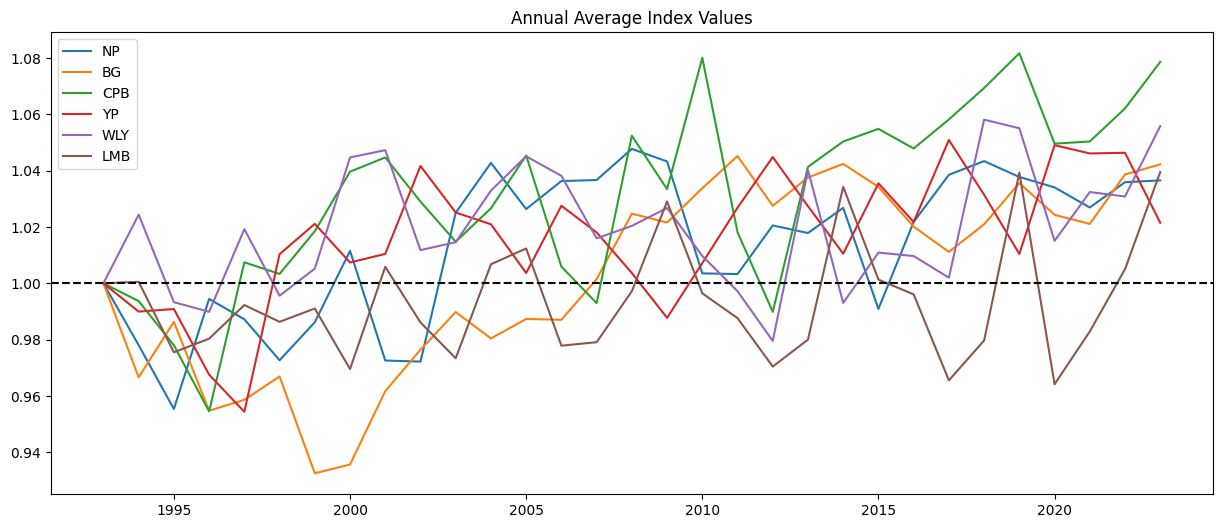

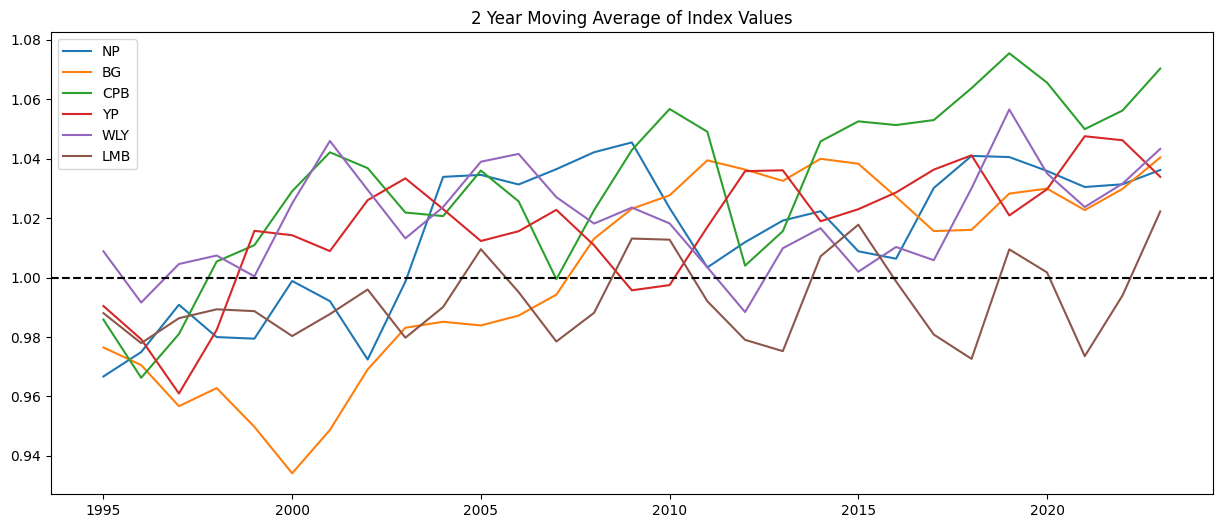

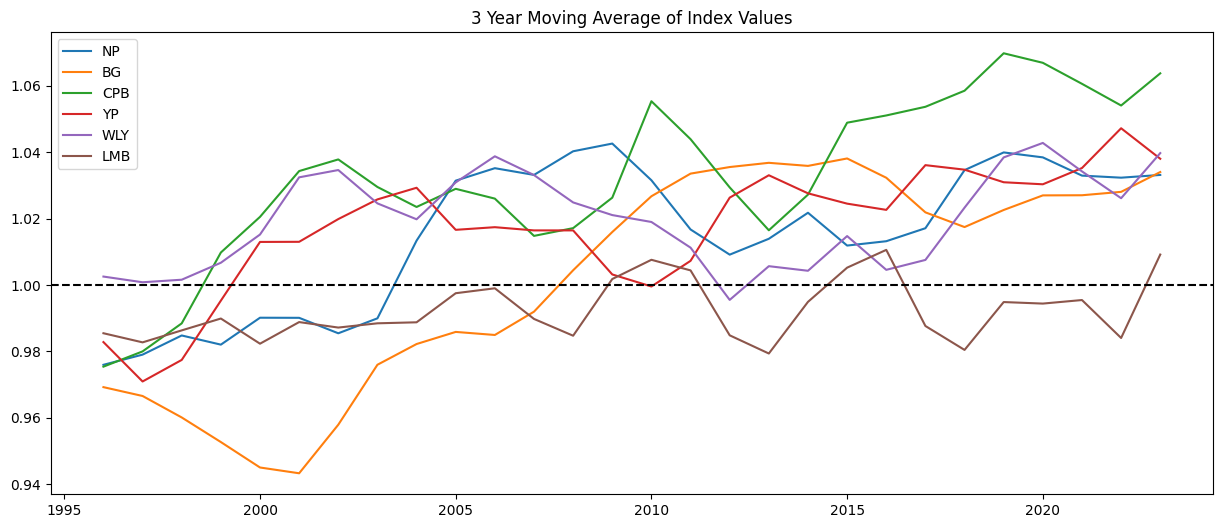

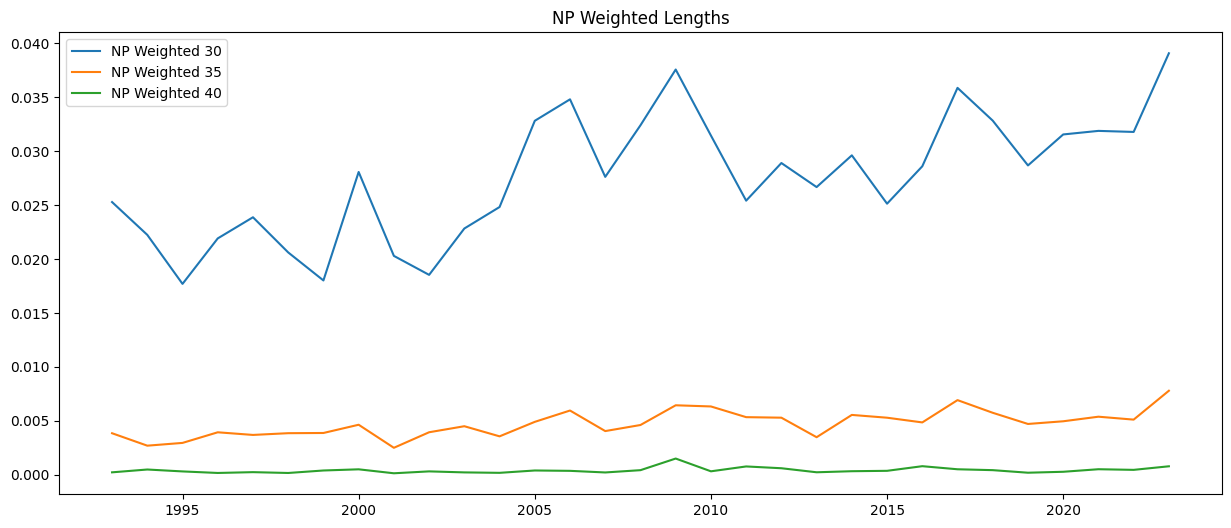

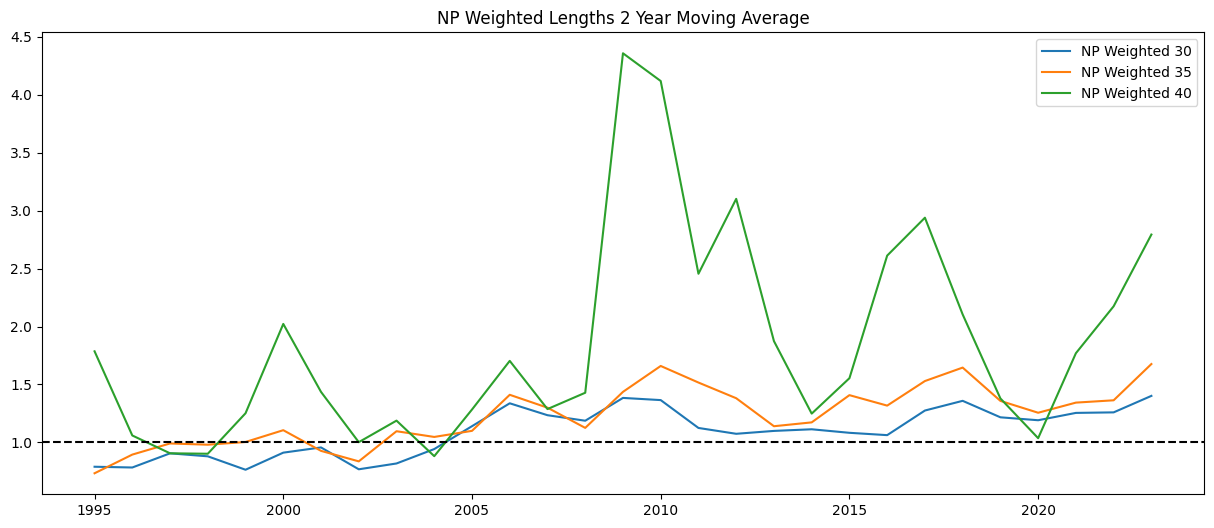

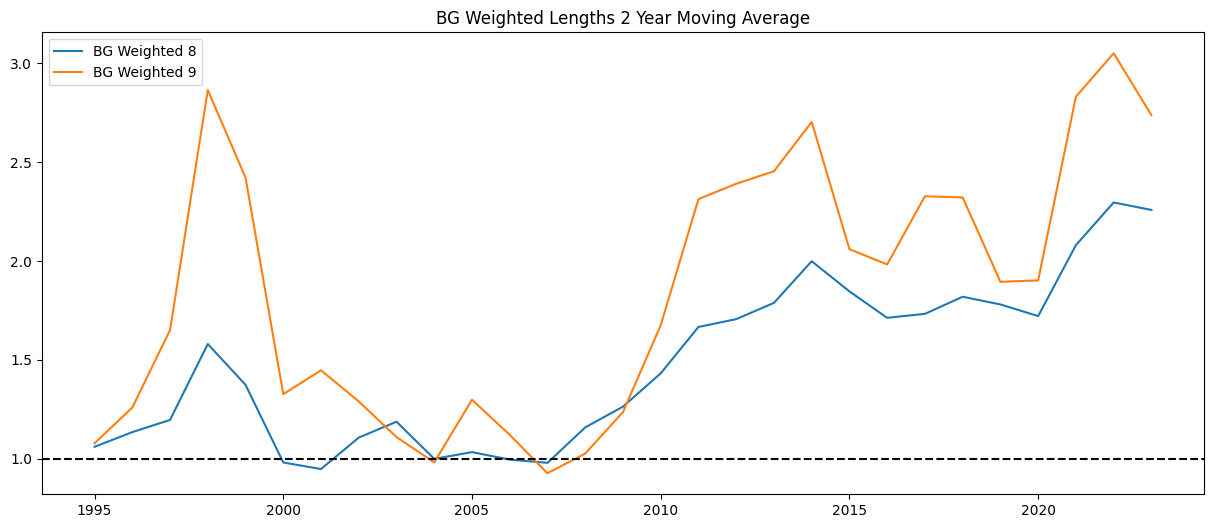

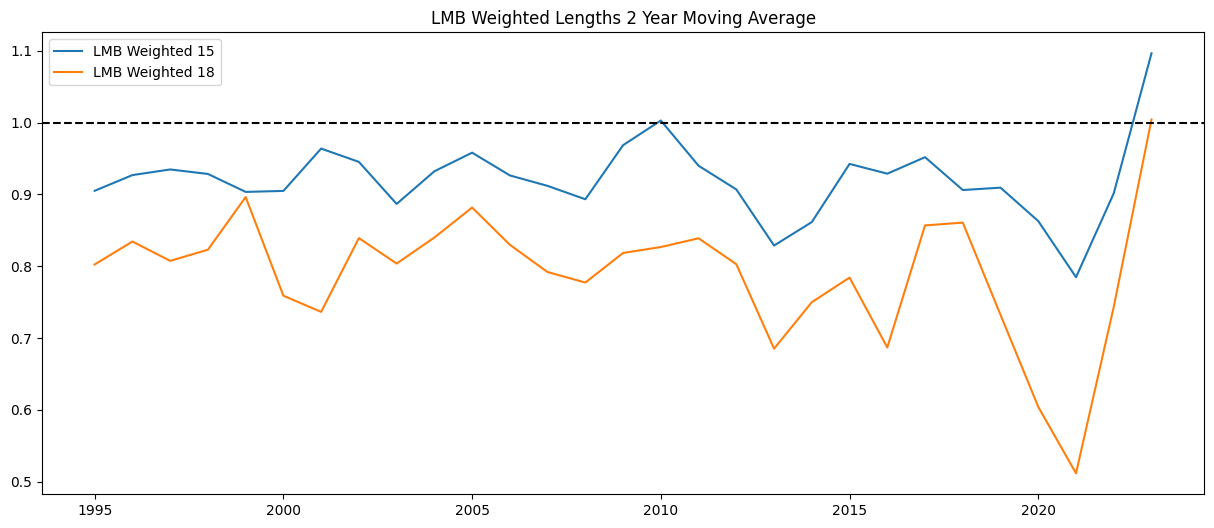

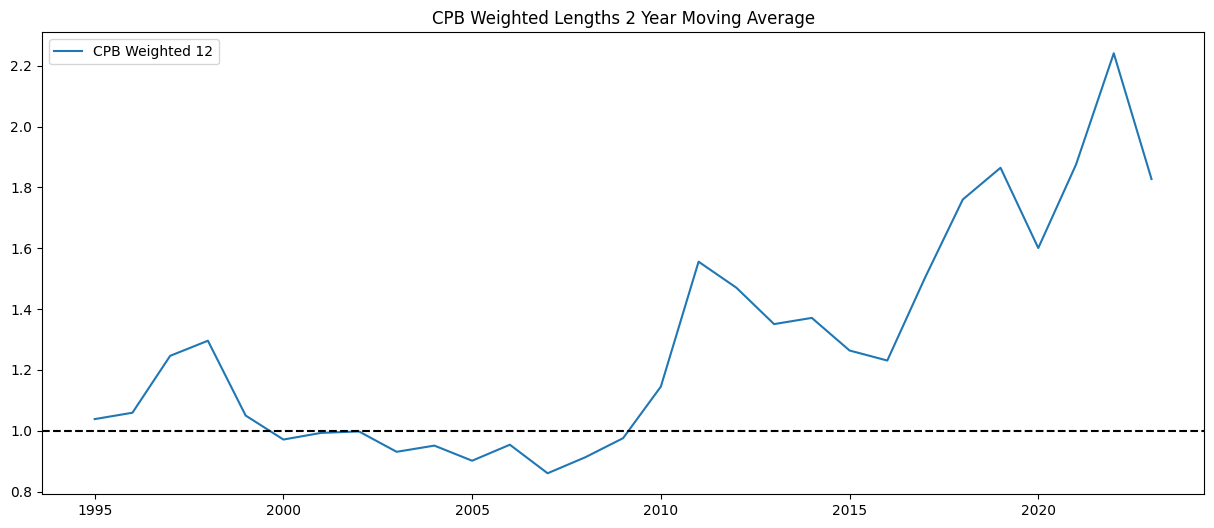

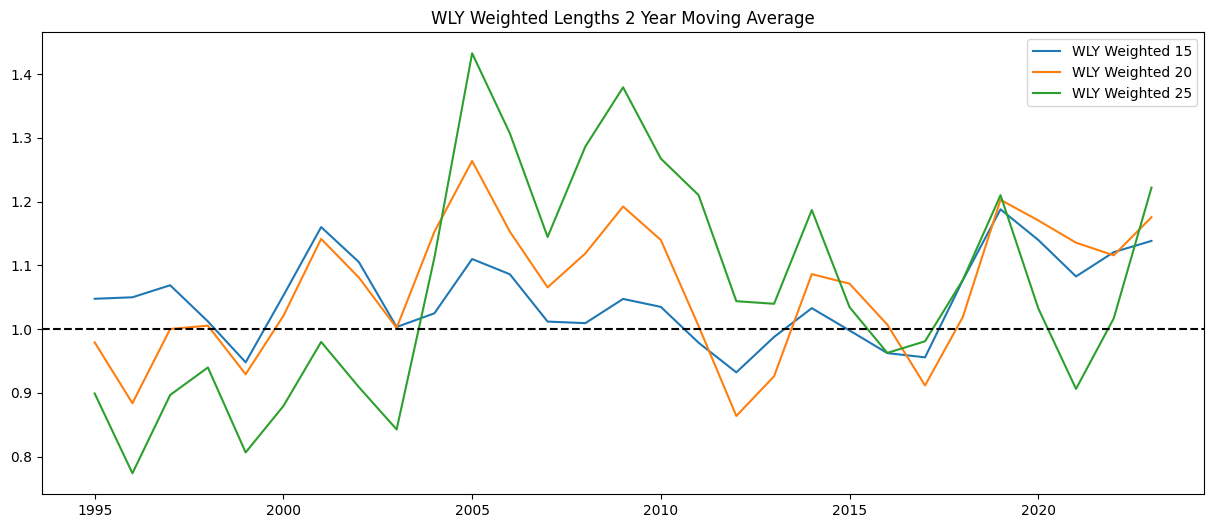

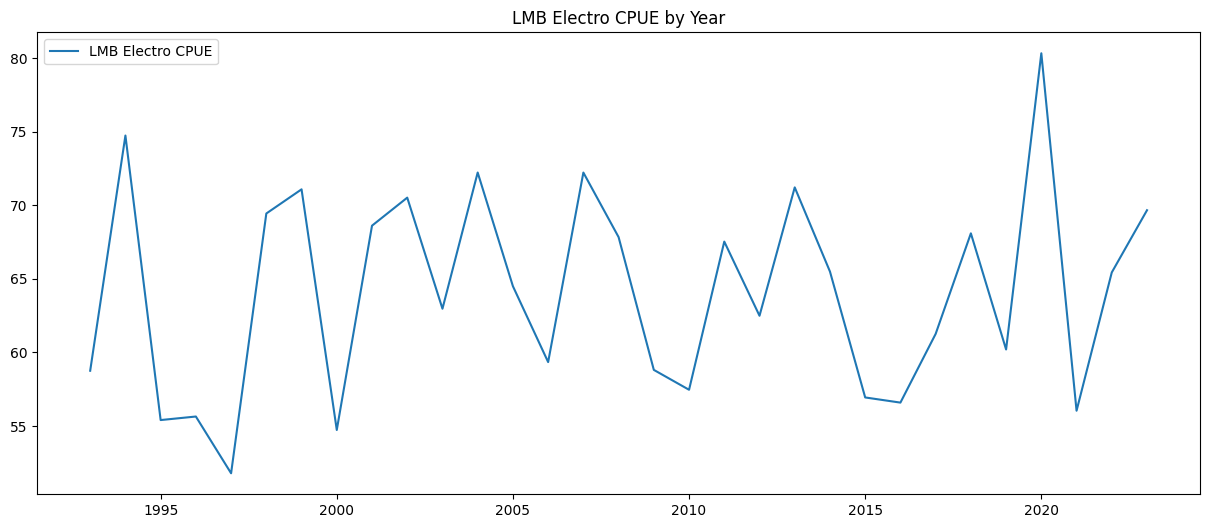

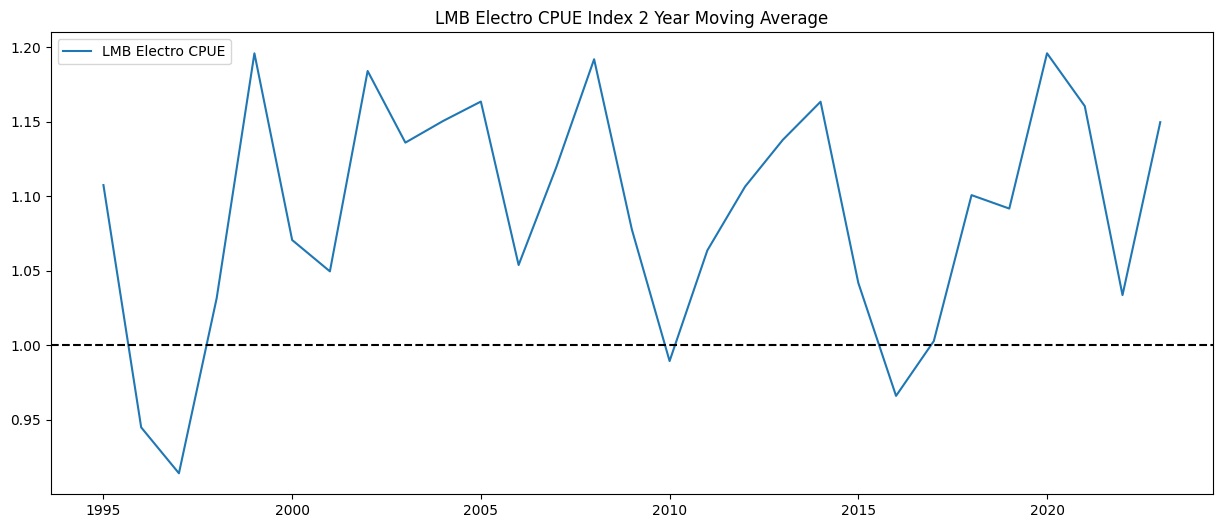

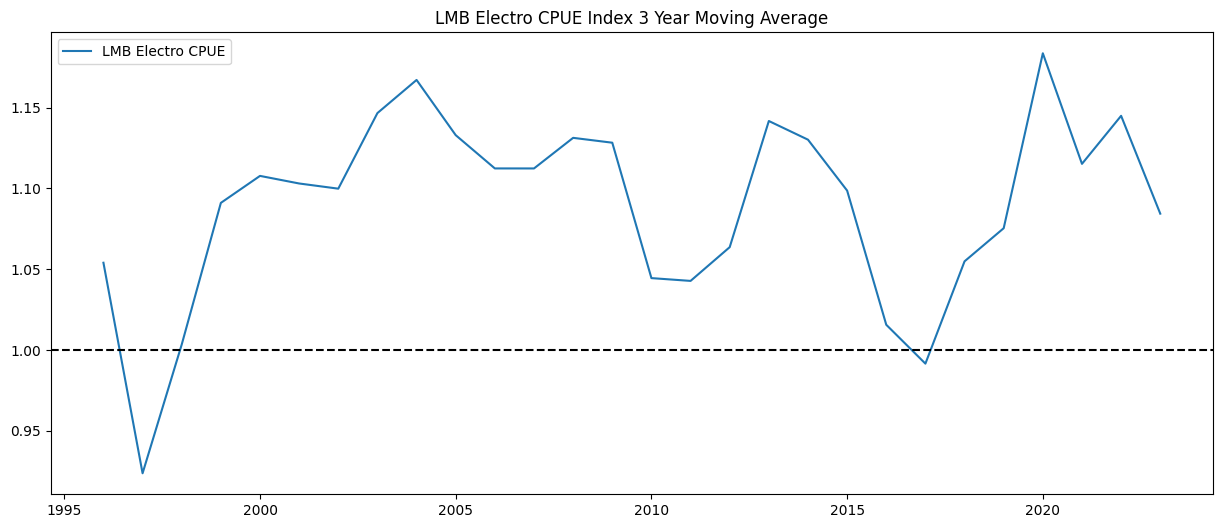

In [8]:
#Create summaries by year to look at trends over time

q = """SELECT survey_year
        , count(1) as cnt
        , sum(case when NP_avg_length is not null then 1 else 0 end) as has_avg
        , avg(CAST(NP_avg_length AS DOUBLE)) as NP_avg_length
        , avg(CAST(BG_avg_length AS DOUBLE)) as BG_avg_length
        , avg(CAST(CPB_avg_length AS DOUBLE)) as CPB_avg_length
        , avg(CAST(YP_avg_length AS DOUBLE)) as YP_avg_length
        , avg(CAST(WLY_avg_length AS DOUBLE)) as WLY_avg_length
        , avg(CAST(LMB_avg_length AS DOUBLE)) as LMB_avg_length
        , avg(CAST(NP_weighted_30 AS DOUBLE)) as NP_weighted_30
        , avg(CAST(NP_weighted_35 AS DOUBLE)) as NP_weighted_35
        , avg(CAST(NP_weighted_40 AS DOUBLE)) as NP_weighted_40
        , avg(CAST(LMB_weighted_15 AS DOUBLE)) as LMB_weighted_15
        , avg(CAST(LMB_weighted_18 AS DOUBLE)) as LMB_weighted_18
        , avg(CAST(BG_weighted_8 AS DOUBLE)) as BG_weighted_8
        , avg(CAST(BG_weighted_9 AS DOUBLE)) as BG_weighted_9
        , avg(CAST(CPB_weighted_12 AS DOUBLE)) as CPB_weighted_12
        , avg(CAST(WLY_weighted_15 AS DOUBLE)) as WLY_weighted_15
        , avg(CAST(WLY_weighted_20 AS DOUBLE)) as WLY_weighted_20
        , avg(CAST(WLY_weighted_25 AS DOUBLE)) as WLY_weighted_25
        , avg(CAST(LMB_electro_CPUE AS DOUBLE)) as LMB_electro_CPUE
        
        
    from lake_master_all
    where survey_year >= 1993
    group by 1 order by 1"""

yearly_avg = qr(q).to_df()

#using the yearly_avg table, I want to index the np_avg_length, bg_avg_length, cpb_avg_length, yp_avg_length, wly_avg_length, and lmb_avg_length columns for survey_year > 1993, using 1993 as the base year
#I will then use these indexed values to calculate the average of the indexed values for each year

#calculate the index for each species
yearly_avg['NP_avg_length_index'] = yearly_avg['NP_avg_length'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'NP_avg_length'].values[0]
yearly_avg['BG_avg_length_index'] = yearly_avg['BG_avg_length'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'BG_avg_length'].values[0]
yearly_avg['CPB_avg_length_index'] = yearly_avg['CPB_avg_length'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'CPB_avg_length'].values[0]
yearly_avg['YP_avg_length_index'] = yearly_avg['YP_avg_length'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'YP_avg_length'].values[0]
yearly_avg['WLY_avg_length_index'] = yearly_avg['WLY_avg_length'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'WLY_avg_length'].values[0]
yearly_avg['LMB_avg_length_index'] = yearly_avg['LMB_avg_length'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'LMB_avg_length'].values[0]

yearly_avg['LMB_electro_CPUE_index'] = yearly_avg['LMB_electro_CPUE'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'LMB_electro_CPUE'].values[0]

#create a 2 year moving average of the index values
yearly_avg['NP_avg_length_index_2yr_avg'] = yearly_avg['NP_avg_length_index'].rolling(window=2).mean()
yearly_avg['BG_avg_length_index_2yr_avg'] = yearly_avg['BG_avg_length_index'].rolling(window=2).mean()
yearly_avg['CPB_avg_length_index_2yr_avg'] = yearly_avg['CPB_avg_length_index'].rolling(window=2).mean()
yearly_avg['YP_avg_length_index_2yr_avg'] = yearly_avg['YP_avg_length_index'].rolling(window=2).mean()
yearly_avg['WLY_avg_length_index_2yr_avg'] = yearly_avg['WLY_avg_length_index'].rolling(window=2).mean()
yearly_avg['LMB_avg_length_index_2yr_avg'] = yearly_avg['LMB_avg_length_index'].rolling(window=2).mean()

yearly_avg['LMB_electro_CPUE_index_2yr_avg'] = yearly_avg['LMB_electro_CPUE_index'].rolling(window=2).mean()

#create a 3 year moving average of the index values
yearly_avg['NP_avg_length_index_3yr_avg'] = yearly_avg['NP_avg_length_index'].rolling(window=3).mean()
yearly_avg['BG_avg_length_index_3yr_avg'] = yearly_avg['BG_avg_length_index'].rolling(window=3).mean()
yearly_avg['CPB_avg_length_index_3yr_avg'] = yearly_avg['CPB_avg_length_index'].rolling(window=3).mean()
yearly_avg['YP_avg_length_index_3yr_avg'] = yearly_avg['YP_avg_length_index'].rolling(window=3).mean()
yearly_avg['WLY_avg_length_index_3yr_avg'] = yearly_avg['WLY_avg_length_index'].rolling(window=3).mean()
yearly_avg['LMB_avg_length_index_3yr_avg'] = yearly_avg['LMB_avg_length_index'].rolling(window=3).mean()

yearly_avg['LMB_electro_CPUE_index_3yr_avg'] = yearly_avg['LMB_electro_CPUE_index'].rolling(window=3).mean()
#calculate index for the weighted lengths
yearly_avg['NP_weighted_30_index'] = yearly_avg['NP_weighted_30'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'NP_weighted_30'].values[0]
yearly_avg['NP_weighted_35_index'] = yearly_avg['NP_weighted_35'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'NP_weighted_35'].values[0]
yearly_avg['NP_weighted_40_index'] = yearly_avg['NP_weighted_40'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'NP_weighted_40'].values[0]
yearly_avg['LMB_weighted_15_index'] = yearly_avg['LMB_weighted_15'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'LMB_weighted_15'].values[0]
yearly_avg['LMB_weighted_18_index'] = yearly_avg['LMB_weighted_18'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'LMB_weighted_18'].values[0]
yearly_avg['BG_weighted_8_index'] = yearly_avg['BG_weighted_8'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'BG_weighted_8'].values[0]
yearly_avg['BG_weighted_9_index'] = yearly_avg['BG_weighted_9'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'BG_weighted_9'].values[0]
yearly_avg['CPB_weighted_12_index'] = yearly_avg['CPB_weighted_12'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'CPB_weighted_12'].values[0]
yearly_avg['WLY_weighted_15_index'] = yearly_avg['WLY_weighted_15'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'WLY_weighted_15'].values[0]
yearly_avg['WLY_weighted_20_index'] = yearly_avg['WLY_weighted_20'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'WLY_weighted_20'].values[0]
yearly_avg['WLY_weighted_25_index'] = yearly_avg['WLY_weighted_25'] / yearly_avg.loc[yearly_avg['survey_year'] == 1993, 'WLY_weighted_25'].values[0]
#create a 2 year moving average of the weighted index values
yearly_avg['NP_weighted_30_index_2yr_avg'] = yearly_avg['NP_weighted_30_index'].rolling(window=2).mean()
yearly_avg['NP_weighted_35_index_2yr_avg'] = yearly_avg['NP_weighted_35_index'].rolling(window=2).mean()
yearly_avg['NP_weighted_40_index_2yr_avg'] = yearly_avg['NP_weighted_40_index'].rolling(window=2).mean()
yearly_avg['LMB_weighted_15_index_2yr_avg'] = yearly_avg['LMB_weighted_15_index'].rolling(window=2).mean()
yearly_avg['LMB_weighted_18_index_2yr_avg'] = yearly_avg['LMB_weighted_18_index'].rolling(window=2).mean()
yearly_avg['BG_weighted_8_index_2yr_avg'] = yearly_avg['BG_weighted_8_index'].rolling(window=2).mean()
yearly_avg['BG_weighted_9_index_2yr_avg'] = yearly_avg['BG_weighted_9_index'].rolling(window=2).mean()
yearly_avg['CPB_weighted_12_index_2yr_avg'] = yearly_avg['CPB_weighted_12_index'].rolling(window=2).mean()
yearly_avg['WLY_weighted_15_index_2yr_avg'] = yearly_avg['WLY_weighted_15_index'].rolling(window=2).mean()
yearly_avg['WLY_weighted_20_index_2yr_avg'] = yearly_avg['WLY_weighted_20_index'].rolling(window=2).mean()
yearly_avg['WLY_weighted_25_index_2yr_avg'] = yearly_avg['WLY_weighted_25_index'].rolling(window=2).mean()




#plot the index values all on the same graph; make a horizontal line at 1 to show the base year
plt.figure(figsize=(15, 6))
plt.title('Annual Average Index Values')

plt.plot(yearly_avg['survey_year'], yearly_avg['NP_avg_length_index'], label='NP')
plt.plot(yearly_avg['survey_year'], yearly_avg['BG_avg_length_index'], label='BG')
plt.plot(yearly_avg['survey_year'], yearly_avg['CPB_avg_length_index'], label='CPB')
plt.plot(yearly_avg['survey_year'], yearly_avg['YP_avg_length_index'], label='YP')
plt.plot(yearly_avg['survey_year'], yearly_avg['WLY_avg_length_index'], label='WLY')
plt.plot(yearly_avg['survey_year'], yearly_avg['LMB_avg_length_index'], label='LMB')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the 2 year moving average of the index values all on the same graph; Only u make a horizontal line at 1 to show the base year; only graph years 1995 and later
plt.figure(figsize=(15, 6))
plt.title('2 Year Moving Average of Index Values')

#only years 1996 and later
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'NP_avg_length_index_2yr_avg'], label='NP')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'BG_avg_length_index_2yr_avg'], label='BG')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'CPB_avg_length_index_2yr_avg'], label='CPB')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'YP_avg_length_index_2yr_avg'], label='YP')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'WLY_avg_length_index_2yr_avg'], label='WLY')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'LMB_avg_length_index_2yr_avg'], label='LMB')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the 3 year moving average of the index values all on the same graph; Only u make a horizontal line at 1 to show the base year; only graph years 1996 and later

plt.figure(figsize=(15, 6))
plt.title('3 Year Moving Average of Index Values')

#only years 1996 and later
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'NP_avg_length_index_3yr_avg'], label='NP')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'BG_avg_length_index_3yr_avg'], label='BG')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'CPB_avg_length_index_3yr_avg'], label='CPB')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'YP_avg_length_index_3yr_avg'], label='YP')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'WLY_avg_length_index_3yr_avg'], label='WLY')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'LMB_avg_length_index_3yr_avg'], label='LMB')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the NP_weighted_30, NP_weighted_35, NP_weighted_40
plt.figure(figsize=(15, 6))
plt.title('NP Weighted Lengths')

plt.plot(yearly_avg['survey_year'], yearly_avg['NP_weighted_30'], label='NP Weighted 30')
plt.plot(yearly_avg['survey_year'], yearly_avg['NP_weighted_35'], label='NP Weighted 35')
plt.plot(yearly_avg['survey_year'], yearly_avg['NP_weighted_40'], label='NP Weighted 40')
plt.legend()
plt.show()

#plot the two year moving average of the NP indexes
plt.figure(figsize=(15, 6))
plt.title('NP Weighted Lengths 2 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'NP_weighted_30_index_2yr_avg'], label='NP Weighted 30')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'NP_weighted_35_index_2yr_avg'], label='NP Weighted 35')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'NP_weighted_40_index_2yr_avg'], label='NP Weighted 40')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the two year moving average of the BG indexes
plt.figure(figsize=(15, 6))
plt.title('BG Weighted Lengths 2 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'BG_weighted_8_index_2yr_avg'], label='BG Weighted 8')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'BG_weighted_9_index_2yr_avg'], label='BG Weighted 9')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the two year moving average of the LMB indexes
plt.figure(figsize=(15, 6))
plt.title('LMB Weighted Lengths 2 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'LMB_weighted_15_index_2yr_avg'], label='LMB Weighted 15')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'LMB_weighted_18_index_2yr_avg'], label='LMB Weighted 18')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the two year moving average of the CPB indexes
plt.figure(figsize=(15, 6))
plt.title('CPB Weighted Lengths 2 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'CPB_weighted_12_index_2yr_avg'], label='CPB Weighted 12')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot the two year moving average of the WLY indexes
plt.figure(figsize=(15, 6))
plt.title('WLY Weighted Lengths 2 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'WLY_weighted_15_index_2yr_avg'], label='WLY Weighted 15')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'WLY_weighted_20_index_2yr_avg'], label='WLY Weighted 20')
plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'WLY_weighted_25_index_2yr_avg'], label='WLY Weighted 25')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#plot LMB_electro_CPUE by year
plt.figure(figsize=(15, 6))
plt.title('LMB Electro CPUE by Year')

plt.plot(yearly_avg['survey_year'], yearly_avg['LMB_electro_CPUE'], label='LMB Electro CPUE')
plt.legend()
plt.show()

#plot LMB_electro_CPUE_index_2yr_avg by year
plt.figure(figsize=(15, 6))
plt.title('LMB Electro CPUE Index 2 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1995, 'LMB_electro_CPUE_index_2yr_avg'], label='LMB Electro CPUE')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()

#LMB_electro_CPUE_index_3yr_avg by year
plt.figure(figsize=(15, 6))
plt.title('LMB Electro CPUE Index 3 Year Moving Average')

plt.plot(yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'survey_year'], yearly_avg.loc[yearly_avg['survey_year'] >= 1996, 'LMB_electro_CPUE_index_3yr_avg'], label='LMB Electro CPUE')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()
plt.show()





In [9]:
#lake class summaries

q = """
SELECT DISTINCT
    lake_class,
    count(1) AS count,
    avg(NULLIF(area, '0')) as avg_area,
    avg(NULLIF(littoral_area, '0')) as avg_littoral_area,
    avg(NULLIF(shore_length, '0')) as avg_shore_length,
    avg(NULLIF(shore_length_ratio, '0'))*100 as shore_length_ratio,
    avg(NULLIF(mean_depth, '0')) as avg_mean_depth,
    avg(NULLIF(max_depth, '0')) as avg_max_depth,
    avg(NULLIF(avg_clarity, 0)) as avg_clarity,
    avg(NULLIF(distance_from_home, 0)) as avg_distance_from_home,
    avg(NULLIF(NP_cpue_prcntl_year, 0)) as avg_np_cpue_prcntl_year,
    avg(NULLIF(NP_weigth_prcntl_year, 0)) as avg_np_weigth_prcntl_year,
    avg(NULLIF(NP_combined_prcntl, 0)) as avg_np_combined_prcntl,
    avg(NULLIF(NP_30_plus_prcnt, 0)) as avg_np_30_plus_prcnt,
    avg(NULLIF(NP_weighted_30, 0)) as avg_np_weighted_30,
    avg(NULLIF(NP_35_plus_prcnt, 0)) as avg_np_35_plus_prcnt,
    avg(NULLIF(NP_weighted_35, 0)) as avg_np_weighted_35,
    avg(NULLIF(NP_40_plus_prcnt, 0)) as avg_np_40_plus_prcnt,
    avg(NULLIF(NP_weighted_40, 0)) as avg_np_weighted_40,
    avg(NULLIF(LMB_prcnt_gte_12, 0)) as avg_lmb_prcnt_gte_12,
    avg(NULLIF(LMB_prcnt_gte_15, 0)) as avg_lmb_prcnt_gte_15,
    avg(NULLIF(LMB_weighted_15, 0)) as avg_lmb_weighted_15,
    avg(NULLIF(LMB_prcnt_gte_18, 0)) as avg_lmb_prcnt_gte_18,
    avg(NULLIF(LMB_weighted_18, 0)) as avg_lmb_weighted_18,
    avg(NULLIF(LMB_cpue_prcntl, 0)) as avg_lmb_cpue_prcntl,
    avg(NULLIF(LMB_weight_prcntl, 0)) as avg_lmb_weight_prcntl,
    avg(NULLIF(LMB_combined_prcntl, 0)) as avg_lmb_combined_prcntl,
    avg(NULLIF(BG_cpue_prcntl_year, 0)) as avg_bg_cpue_prcntl_year,
    avg(NULLIF(BG_weigth_prcntl_year, 0)) as avg_bg_weigth_prcntl_year,
    avg(NULLIF(BG_combined_prcntl, 0)) as avg_bg_combined_prcntl,
    avg(NULLIF(BG_7_plus_prcnt, 0)) as avg_bg_7_plus_prcnt,
    avg(NULLIF(BG_8_plus_prcnt, 0)) as avg_bg_8_plus_prcnt,
    avg(NULLIF(BG_weighted_8, 0)) as avg_bg_weighted_8,
    avg(NULLIF(BG_9_plus_prcnt, 0)) as avg_bg_9_plus_prcnt,
    avg(NULLIF(BG_10_plus_prcnt, 0)) as avg_bg_10_plus_prcnt,
    avg(NULLIF(CPB_cpue_prcntl_year, 0)) as avg_cpb_cpue_prcntl_year,
    avg(NULLIF(CPB_weigth_prcntl_year, 0)) as avg_cpb_weigth_prcntl_year,
    avg(NULLIF(CPB_combined_prcntl, 0)) as avg_cpb_combined_prcntl,
    avg(NULLIF(CPB_10_plus_prcnt, 0)) as avg_cpb_10_plus_prcnt,
    avg(NULLIF(CPB_11_plus_prcnt, 0)) as avg_cpb_11_plus_prcnt,
    avg(NULLIF(CPB_12_plus_prcnt, 0)) as avg_cpb_12_plus_prcnt,
    avg(NULLIF(CPB_weighted_12, 0)) as avg_cpb_weighted_12,
    avg(NULLIF(YP_cpue_prcntl_year, 0)) as avg_yp_cpue_prcntl_year,
    avg(NULLIF(YP_weigth_prcntl_year, 0)) as avg_yp_weigth_prcntl_year,
    avg(NULLIF(YP_combined_prcntl, 0)) as avg_yp_combined_prcntl,
    avg(NULLIF(WLY_cpue_prcntl_year, 0)) as avg_wly_cpue_prcntl_year,
    avg(NULLIF(WLY_weigth_prcntl_year, 0)) as avg_wly_weigth_prcntl_year,
    avg(NULLIF(WLY_combined_prcntl, 0)) as avg_wly_combined_prcntl,
    avg(NULLIF(WLY_15_plus_prcnt, 0)) as avg_wly_15_plus_prcnt,
    avg(NULLIF(WLY_weighted_15, 0)) as avg_wly_weighted_15,
    avg(NULLIF(WLY_20_plus_prcnt, 0)) as avg_wly_20_plus_prcnt,
    avg(NULLIF(WLY_weighted_20, 0)) as avg_wly_weighted_20,
    avg(NULLIF(WLY_25_plus_prcnt, 0)) as avg_wly_25_plus_prcnt,
    avg(NULLIF(WLY_weighted_25, 0)) as avg_wly_weighted_25
FROM lake_master_latest_stg
GROUP BY lake_class
ORDER BY lake_class;

"""



lake_class_summary = qr(q).to_df()

#export the lake_class_summary table to a csv file
# lake_class_summary.to_csv(r'lake_class_summary.csv', index = False)
lake_class_summary

,lake_class,count,avg_area,avg_littoral_area,avg_shore_length,shore_length_ratio,avg_mean_depth,avg_max_depth,avg_clarity,avg_distance_from_home,...,avg_yp_combined_prcntl,avg_wly_cpue_prcntl_year,avg_wly_weigth_prcntl_year,avg_wly_combined_prcntl,avg_wly_15_plus_prcnt,avg_wly_weighted_15,avg_wly_20_plus_prcnt,avg_wly_weighted_20,avg_wly_25_plus_prcnt,avg_wly_weighted_25
0,0.0,273,144.575465,142.957246,2.548951,4.013808,29.584211,42.364341,10.410169,138.767606,...,0.461856,0.461855,0.550399,0.483766,0.674526,0.352721,0.323507,0.134773,0.061799,0.032255
1,1.0,35,3040.522000,620.482353,47.958286,1.596550,34.128571,132.371429,17.387500,245.047619,...,0.240168,0.485246,0.458441,0.443991,0.406300,0.209532,0.140603,0.071067,0.036069,0.023415
2,2.0,10,35971.179000,6369.000000,389.611000,1.284930,42.850000,125.900000,11.290000,212.833333,...,0.583935,0.775278,0.201758,0.391833,0.246049,0.203043,0.091930,0.074564,0.012223,0.010211
3,3.0,71,291.170845,94.074627,7.887465,2.878969,29.125000,77.535211,14.241818,240.656250,...,0.220953,0.416767,0.564685,0.544887,0.601342,0.273290,0.275730,0.123957,0.087961,0.033663
4,4.0,41,54.899024,15.464103,1.520732,3.319255,24.066667,56.585366,16.014286,221.888889,...,0.360516,0.115874,0.737607,0.233147,0.888889,0.102109,0.666667,0.064940,0.111111,0.027390
5,5.0,62,366.625161,139.387097,5.352581,1.660506,23.785714,47.129032,12.283019,192.214286,...,0.472298,0.515459,0.549058,0.503574,0.666572,0.297219,0.338059,0.117992,0.159573,0.033762
6,6.0,46,273.243478,177.643182,7.926739,3.442927,13.020000,38.695652,8.556410,234.423077,...,0.339272,0.551586,0.306322,0.349197,0.399850,0.182065,0.139027,0.051153,0.068828,0.028107
7,7.0,40,1792.678000,734.727632,26.422250,1.804721,15.166667,49.770000,7.850000,211.047619,...,0.520564,0.640772,0.303050,0.391373,0.358330,0.206833,0.171609,0.088120,0.064414,0.029425
8,8.0,71,59.057183,33.245312,2.076338,3.915531,13.375000,34.760563,11.371429,236.477273,...,0.360276,0.404855,0.480231,0.390554,0.586877,0.221201,0.264047,0.101116,0.138889,0.062558
9,9.0,44,18.096818,12.195122,0.904091,5.866402,10.541667,24.988636,8.343750,216.809524,...,0.492306,0.491793,0.461628,0.444947,0.680392,0.344487,0.588235,0.346761,0.058824,0.034676


In [10]:
from sklearn.linear_model import LinearRegression
cluster_lake_master_latest = lake_master_latest

import numpy as np

#create a variable that is a list of the following columns: 'NP_combined_prcntl', 'LMB_combined_prcntl', 'BG_combined_prcntl', 'CPB_combined_prcntl', 'YP_combined_prcntl', 'WLY_combined_prcntl'
# cols = ['NP_combined_prcntl', 'LMB_combined_prcntl', 'BG_combined_prcntl', 'CPB_combined_prcntl', 'YP_combined_prcntl', 'WLY_combined_prcntl']


#for avg_clarity, max_depth,shore_length and littoral_area  transform nulls to be the mean of the column
# cluster_lake_master_latest['avg_clarity'] = cluster_lake_master_latest['avg_clarity'].fillna(cluster_lake_master_latest['avg_clarity'].mean())
# cluster_lake_master_latest['max_depth'] = cluster_lake_master_latest['max_depth'].fillna(cluster_lake_master_latest['max_depth'].mean())
# cluster_lake_master_latest['shore_length'] = cluster_lake_master_latest['shore_length'].fillna(cluster_lake_master_latest['shore_length'].mean())

cols = ['area','avg_clarity','max_depth','shore_length','littoral_area','lake_lattitude','lake_longitude','NP_combined_prcntl']


#create a subset of lake_master_latest that only excludes data where any of the columns in cols are null
cluster_lake_master_latest = cluster_lake_master_latest[cluster_lake_master_latest[cols].notnull().all(axis=1)]

cluster_lake_master_latest['littoral_area'] = cluster_lake_master_latest['littoral_area'].str.replace(',', '').astype(float)
cluster_lake_master_latest['area'] = cluster_lake_master_latest['area'].str.replace(',', '').astype(float)

#exclude Lake of the woods and Rainy
cluster_lake_master_latest = cluster_lake_master_latest[~cluster_lake_master_latest['lake_id'].isin(['39000200','69069400'])]

#identify what buckets or combinations of 'area','avg_clarity','max_depth','shore_length','littoral_area','lake_lattitude','lake_longitude' are the best predictors of the following columns: 'NP_combined_prcntl'
# Select the relevant columns for analysis
features = ['area', 'avg_clarity', 'max_depth', 'shore_length', 'littoral_area', 'lake_lattitude', 'lake_longitude']
target = 'NP_combined_prcntl'

# Create the feature matrix X and the target vector y
X = cluster_lake_master_latest[features]
y = cluster_lake_master_latest[target]

# Create an instance of the Linear Regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# create a dataframe with the model coefficients and t statistics
coefficients = pd.DataFrame({'feature': features, 'coefficient': model.coef_, 't_stat': model.coef_ / np.std(X, 0)})
coefficients




KeyError: "['shore_length', 'littoral_area'] not in index"

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#replace all nulls with 0 for the following columns 'NP_combined_prcntl', 'LMB_combined_prcntl', 'BG_combined_prcntl',
    #    'PNK_combined_prcntl', 'SNH_combined_prcntl', 'SNG_combined_prcntl',
    #    'CPB_combined_prcntl', 'CPW_combined_prcntl', 'YP_combined_prcntl',
    #    'WLY_combined_prcntl'
# lake_master_latest['NP_combined_prcntl'] = lake_master_latest['NP_combined_prcntl'].fillna(0)
# lake_master_latest['LMB_combined_prcntl'] = lake_master_latest['LMB_combined_prcntl'].fillna(0)
# lake_master_latest['BG_combined_prcntl'] = lake_master_latest['BG_combined_prcntl'].fillna(0)
# lake_master_latest['CPB_combined_prcntl'] = lake_master_latest['CPB_combined_prcntl'].fillna(0)
# lake_master_latest['YP_combined_prcntl'] = lake_master_latest['YP_combined_prcntl'].fillna(0)
# lake_master_latest['WLY_combined_prcntl'] = lake_master_latest['WLY_combined_prcntl'].fillna(0)

cluster_lake_master_latest = lake_master_latest

#create a variable that is a list of the following columns: 'NP_combined_prcntl', 'LMB_combined_prcntl', 'BG_combined_prcntl', 'CPB_combined_prcntl', 'YP_combined_prcntl', 'WLY_combined_prcntl'
# cols = ['NP_combined_prcntl', 'LMB_combined_prcntl', 'BG_combined_prcntl', 'CPB_combined_prcntl', 'YP_combined_prcntl', 'WLY_combined_prcntl']


#for avg_clarity, max_depth,shore_length and littoral_area  transform nulls to be the mean of the column
cluster_lake_master_latest['avg_clarity'] = cluster_lake_master_latest['avg_clarity'].fillna(cluster_lake_master_latest['avg_clarity'].mean())
cluster_lake_master_latest['max_depth'] = cluster_lake_master_latest['max_depth'].fillna(cluster_lake_master_latest['max_depth'].mean())
cluster_lake_master_latest['shore_length'] = cluster_lake_master_latest['shore_length'].fillna(cluster_lake_master_latest['shore_length'].mean())

cols = ['area','avg_clarity','max_depth','shore_length','littoral_area']


#create a subset of lake_master_latest that only excludes data where any of the columns in cols are null
cluster_lake_master_latest = cluster_lake_master_latest[cluster_lake_master_latest[cols].notnull().all(axis=1)]

cluster_lake_master_latest['littoral_area'] = cluster_lake_master_latest['littoral_area'].str.replace(',', '').astype(float)


#exclude Lake of the woods and Rainy
cluster_lake_master_latest = cluster_lake_master_latest[~cluster_lake_master_latest['lake_id'].isin(['39000200','69069400'])]

# cols = ['area','']

# Step 3: Normalize the data
scaler = StandardScaler()
df_lakes_scaled = scaler.fit_transform(cluster_lake_master_latest[cols])

# Step 4: Determine the optimal number of clusters using the elbow method
# sum_of_squared_distances = []
# K = range(1, 15)
# for k in K:
#     km = KMeans(n_clusters=k, random_state=42)
#     km = km.fit(df_lakes_scaled)
#     sum_of_squared_distances.append(km.inertia_)

# # Plot the elbow curve
# plt.plot(K, sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum of squared distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

# Step 5: Run k-means with the optimal number of clusters
km = KMeans(n_clusters=6, random_state=42)
km.fit(df_lakes_scaled)

# Step 6: Analyze the clusters
cluster_lake_master_latest['cluster'] = km.labels_
cluster_lake_master_latest['cluster'].value_counts()

#create a summary table that has all the averages for each cluster, as well as the count of lakes in each cluster
cluster_summary = cluster_lake_master_latest.groupby('cluster').mean().round(2)
cluster_summary

#add the count of lakes in each cluster to the cluster_summary table
cluster_summary['count'] = cluster_lake_master_latest.groupby('cluster').count()['lake_id']
cluster_summary

#export the cluster_summary table to a csv
# cluster_summary.to_csv(r'cluster_summary.csv', index = False)


KeyError: 'shore_length'